### Include
- distribution of raw corpus
- distribution of annotated data
    - overall node count and link count
    - breakdown of node count by taggers and types
    - time-sliced details
    - semantic types for the nodes
    - semantic types for the links
- creating Training data and Testing data
- evaluate learning based models without temporal features 
    - raw tp/fp/tn/fn
    - precision/recall
    - tpr/fpr
    - auroc/aupr
- create temporal features for cn,aa,jc
- evaluate learning based models and supervised learning models with and without temporal features

In [25]:
import json
from collections import defaultdict
import altair as alt
alt.data_transformers.disable_max_rows()
import numpy as np
# alt.data_transformers.enable('data_server')
alt.renderers.enable('default')
import pandas as pd
from itertools import groupby
from collections import OrderedDict
import copy
from itertools import combinations
from collections import Counter
from sklearn.datasets import make_classification,load_iris
from imblearn.under_sampling import RandomUnderSampler 
import math
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score,average_precision_score,roc_curve,precision_recall_curve,auc,confusion_matrix
import pickle
import sklearn.pipeline
import xgboost as xgb
import xmltodict
import networkx as nx
# import matplotlib.pyplot as plt
from sklearn import metrics
# from altair_saver import save
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import sklearn.ensemble
# import sklearn.linear_model
# import sklearn.metrics
# import sklearn.model_selection
# import sklearn.preprocessing


In [26]:
# codes from https://github.com/gerritjandebruin/temporal-link-prediction/blob/main/src/get_features.py
#. for temporal link prediction
import collections
import itertools
import os

import networkx as nx
import scipy.stats
import typer

# from .logger import logger
# from .progress_parallel import ProgressParallel, delayed

app = typer.Typer()

In [10]:
# temporary saving path for the outputs
save_path = "/Users/yidesdo21/Projects/outputs/13_link_prediction/"

In [11]:
# load raw articles without any pre-processing
raw_path = "/Users/yidesdo21/Projects/inputs/articles/06_time_slicing/raw/"
raw_file = "all.txt"   # change if need another year

with open(raw_path+raw_file) as f:
    contents = f.read().replace("\t", "").splitlines()
    


In [12]:
# load the metadata from the json
meta_path = "/Users/yidesdo21/Projects/outputs/12_time_slicing/metadata/"

with open(meta_path+"articles_with_anno.json") as f:
    metadata = json.load(f)

### analyze the distribution of raw AD articles

In [13]:
# grab codes from sample_articles.ipynb 
# draw a distribution of articles in each year with and without abstracts as a stacked bar chart 

# concatenate the title and the abstract into a single list
i = (list(g) for _, g in groupby(contents, key=''.__ne__))
sepa_content = [a + b for a, b in zip(i, i)]

In [14]:
# some articles in endnote library have abstracts, while others don't
# first, check the number of articles that have abstracts and those who don't have


doc_abs, doc_nabs = list(), list()

for i in sepa_content:
    if len(i) != 3:
        doc_nabs.append(i)
    else:
        doc_abs.append(i)
        
print("The number of documents without abstracts:", len(doc_abs))
print("The number of documents with abstracts:", len(doc_nabs))

The number of documents without abstracts: 21864
The number of documents with abstracts: 6221


In [15]:
# next, show the distribution of articles with and without abstracts in year each
#.  build two dictionaries:
#.    one with {year:article_count} for articles with abstracts
#     another with {year:article_count} for articles without abstracts

def create_doc_dict(document):
    """create a dictionary of articles per year without and without articles,
        input -- a set of documents with or without abstracts
        output -- a dictionary {year1:[article1,article2], 
                                year2:[article1,article2], ...}"""
    
    doc = list()
    years = list()
    year_doc = defaultdict(list)
    
    for d in document:
        metadata = d[0].split(";")
        
        if len(metadata) < 3:  # the metadata is in another format, ignore them for now
            continue

        year = metadata[-3]

        if not year.isdigit():  # the metadata is in another format, the year is not the third last item of the metadata
            year = metadata[-2]
            if not year.isdigit():  # the metadata is in another format, ignore the ~20 for now
                continue

        doc.append(d)
        years.append(year)
        year_doc[year].append(d)
    
    
    return year_doc
    
        

In [16]:
# create a dataframe of article counts per year with or without abstracts
def create_distributioin(doc,with_abs="yes"):
    """input -- a set of documents with or without abstracts,
       output -- a dataframe with ["year","article_count","with_abs"] as columns"""
    
    y_doc = create_doc_dict(doc)
    y_doc_cnt = dict()
    
    for k,v in y_doc.items():
        y_doc_cnt[k] = len(v)
    
    year_art_df = pd.DataFrame(y_doc_cnt.items())
    year_art_df = year_art_df.rename(columns={0:"year",1:"article_count"})
    year_art_df['with_abs'] = with_abs
    year_art_df['year'] = year_art_df['year'].astype(int)
        
    return year_art_df


In [17]:
doc_abs_df = create_distributioin(doc_abs,"yes")
doc_nabs_df = create_distributioin(doc_nabs,"no")
doc_df = doc_abs_df.append(doc_nabs_df)

<ipython-input-17-c9cee13c33c0>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  doc_df = doc_abs_df.append(doc_nabs_df)


In [18]:
# this explains why 2007 has a huge drop
# should we try to include the articles without the abstracts into the data?
#.   ad of including them -- if using time slicing or discovery replication, then time plays a role in discovery
# the drop in 2021 is because the dataset is until 2021-06-10, we can take more in the database

abs_chart = alt.Chart(doc_df).mark_bar().encode(
    alt.X("year:N",axis=alt.Axis(title="Year",labelAngle=-45)),
    alt.Y("article_count:Q",title="article count"),
    alt.Color("with_abs:N",title="with abstracts",),
    tooltip=['year',"article_count","with_abs"]
).properties(
    title='The proportion of articles with and without abstracts each year.',
    width=800,
    height=400
)
abs_chart

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [60]:
# save_chart = "/Users/yidesdo21/OneDrive - The University of Melbourne/LBD-backup/confirmation/07_improve_prelimimary_study/lbd_ad_link_prediction/pictures/"



In [19]:
# check the articles without abstracts in 2007, why they don't have an abstract?
#.  no abstracts in the endnote library, but they have the abstracts if searching google for the titles
without_abs, with_abs = create_doc_dict(doc_nabs), create_doc_dict(doc_abs)
doc_nabs_2007 = without_abs.get("2007")
doc_abs_2007 = with_abs.get("2007")

# print(doc_nabs_2007[:5])
# print("-------------")
# print(doc_abs_2007[:2])

### analyze the distribution of AD articles after taking metadata

In [20]:
# process each year's annotation data in python, 
# only the articles with PMID has annotations

# year_nio_uid, year_ptc_uid = defaultdict(set), defaultdict(set)
# year_uid = defaultdict(set)
year_article = defaultdict(list)
year_article_unfil = defaultdict(list)

for m in metadata:
    year, db, title = m.get("year"), m.get("sourcedb"), m.get("title")
    
    year_article_unfil[year].append(title)
    
    if db == "NLM":
        year_article[year].append(title)
#         nio_uids = m.get("nio_uids")
#         ptc_uids = m.get("ptc_uids")
        
#         if nio_uids is not None:
#             year_nio_uid[year].update(nio_uids)
#             year_uid[year].update(nio_uids)
        
#         if ptc_uids is not None:
#             year_ptc_uid[year].update(ptc_uids)
#             year_uid[year].update(ptc_uids)

In [21]:
# calculate the number of articles in each year 
# group articles before 2000 to 2000 --- shouldn't, the time is important in discoveries 
# check sample_articles.ipynb, before saving the annotation.json file, are the years correct for 2007
year_article_cnt = dict()
accu_2000 = 0

for k,v in year_article.items():
    if int(k) <= 2000:
        accu_2000 += len(v)
    
    else:
        year_article_cnt[k] = len(v)

year_article_cnt["2000"] = accu_2000     

year_article_unf_cnt = dict()
accu_unf_2000 = 0

for k,v in year_article_unfil.items():
    if int(k) <= 2000:
        accu_unf_2000 += len(v)
    
    else:
        year_article_unf_cnt[k] = len(v)

year_article_unf_cnt["2000"] = accu_unf_2000  

In [22]:
year_art_df = pd.DataFrame(year_article_cnt.items())
year_art_df = year_art_df.rename(columns={0:"year",1:"article_count"})
year_art_df['year'] = year_art_df['year'].astype(int)

year_art_unf_df = pd.DataFrame(year_article_unf_cnt.items())
year_art_unf_df = year_art_unf_df.rename(columns={0:"year",1:"article_count"})
year_art_unf_df['year'] = year_art_unf_df['year'].astype(int)

In [23]:
# size of the dataset used for annotation
year_art_df['article_count'].sum()

16452

In [27]:
alt.Chart(year_art_df).mark_bar().encode(
    alt.X("year:N"),
    alt.Y("article_count:Q", title="article count"),
    tooltip=['year',"article_count"]
).properties(
    title="The dataset used for annotator"
)

alt.Chart(...)

In [18]:
# ## even with "CCC" data source, the year 2007 still has a huge drop
# # the endnote library shows 927 articles in 2007, some errors are in the data pre-processing stage
# alt.Chart(year_art_unf_df).mark_bar().encode(
#     alt.X("year:N"),
#     alt.Y("article_count:Q"),
#     tooltip=['year',"article_count"]
# )

### analyze the data from co-occurrence as the hypotheses
- draw a table for data description with columns ["dataset", "node count", "link count", "has dates", "link type"]
- how many nodes exist each year, the nodes in the next year should be new from all previous years
- how many links exist each year, the links in the next year should be new from all previous years
- draw a table for time-sliced details with columns ["dataset", "link use", "time slice", "link count", "link percentage"]
- what types of nodes consist in each year -- new nodes or the old nodes 


In [28]:
# process each year's annotation data into dictionaries, 
#     for nodes: {year1:(set_of_uids),year2:(set_of_uids),...}
# each set of uids in each year can be duplicated from any year

year_nio_uid, year_ptc_uid = defaultdict(set), defaultdict(set)
year_uid = defaultdict(set)

for m in metadata:
    year, db = int(m.get("year")), m.get("sourcedb")
    
    
    if db == "NLM":
        nio_uids = m.get("nio_uids")
        ptc_uids = m.get("ptc_uids")
        
        if nio_uids is not None:
            year_nio_uid[year].update(nio_uids)
            year_uid[year].update(nio_uids)
        
        if ptc_uids is not None:
            year_ptc_uid[year].update(ptc_uids)
            year_uid[year].update(ptc_uids)
            
year_uid = OrderedDict(sorted(year_uid.items()))

In [29]:
# create a dictionary of new nodes each year, {year:(set_of_uids)}
## the uids in each year are new compared to all previous years

# year 2021 is not completed, only articles till June 10, 2021 are included 

accum_v = set()
year_vn = dict()  # new keywords in each year compared to all previous years
year_vo = dict()  # keywords in previous years

for yr,yr_uid in year_uid.items(): 
    previous_nodes = copy.deepcopy(accum_v)  # need to use deepcopy, otherwise the value will updated globally
    year_vo[yr] = previous_nodes
    
    new_nodes = yr_uid.difference(accum_v)
    year_vn[yr] = new_nodes
    accum_v.update(new_nodes)


# create a dictionary of number of new nodes each year, {year:#(set_of_uids)}
year_vn_cnt = dict()
year_vo_cnt = dict()

for k,v in year_vn.items():
    year_vn_cnt[k] = len(v)
    
for k,v in year_vo.items():
    year_vo_cnt[k] = len(v)    
    
accum_v.remove("")

In [30]:
vn_cnt_df = pd.DataFrame(year_vn_cnt.items())
vn_cnt_df = vn_cnt_df.rename(columns={0:"year",1:"node_count"})
vn_cnt_df['new_or_old'] = "new"
vo_cnt_df = pd.DataFrame(year_vo_cnt.items())
vo_cnt_df = vo_cnt_df.rename(columns={0:"year",1:"node_count"})
vo_cnt_df['new_or_old'] = "old"
v_df = vn_cnt_df.append(vo_cnt_df)

In [31]:
# The first node of accum_v is None.
print("The number of distinct nodes in all years:", len(accum_v)-1)

The number of distinct nodes in all years: 11728


In [32]:
# accumualted nodes each year
alt.Chart(v_df).mark_bar().encode(
    alt.X("year:N",axis=alt.Axis(title="Year",labelAngle=-45)),
    alt.Y("node_count:Q",title="Node count"),
    alt.Color("new_or_old:N",title="new node or old node",),
    tooltip=['year',"node_count","new_or_old"]
).properties(
    title='The number of new and old nodes each year.',
    width=800,
    height=400
)

alt.Chart(...)

In [33]:
# process each year's annotation data into dictionaries, 
#     for links: {year1:(set_of_links),year2:(set_of_links),...}
# each set of links in each year can be duplicated from any year
year_edge = defaultdict(set)

# create a duplicate link set to check if there are any duplications
#.   (node1,node2) and (node2,node1) are duplications
dup_link = set()

for m in metadata:   # the edges are on the citation level
    year, db = int(m.get("year")), m.get("sourcedb")
    
    if db == "NLM":
        nio_uids = m.get("nio_uids")
        ptc_uids = m.get("ptc_uids")
        
        if nio_uids is not None and ptc_uids is not None:
            uids = sorted(nio_uids+ptc_uids)
            co_occur = list(combinations(uids, 2))
            links = set(co_occur)
            year_edge[year].update(links)
            
            for link in links:
                node1,node2 = link[0],link[1]
                dup = (node2,node1)
                dup_link.add(dup)
            
year_edge = OrderedDict(sorted(year_edge.items()))

# shouldn't print anything because shouldn't have duplications 
for yr,yr_links in year_edge.items():
    for yr_link in yr_links:
        if yr_link in dup_link:
            print(yr_link)

In [34]:
# create a dictionary of new links each year, {year:(set_of_links)}
## the links in each year are new compared to all previous years

# year 2021 is not completed, only articles till June 10, 2021 are included 

accum_l = set()
year_ln = dict()  # new links in each year compared to all previous years
year_lo = dict()  # links in previous years

for yr,yr_link in year_edge.items(): 
    previous_links = copy.deepcopy(accum_l)  # need to use deepcopy, otherwise the value will updated globally
    year_lo[yr] = previous_links
    
    new_links = yr_link.difference(accum_l)
    year_ln[yr] = new_links
    accum_l.update(new_links)


# create a dictionary of number of new links each year, {year:#(set_of_links)}
year_ln_cnt = dict()
year_lo_cnt = dict()

for k,v in year_ln.items():
    year_ln_cnt[k] = len(v)
    
for k,v in year_lo.items():
    year_lo_cnt[k] = len(v)    
    


In [35]:
ln_cnt_df = pd.DataFrame(year_ln_cnt.items())
ln_cnt_df = ln_cnt_df.rename(columns={0:"year",1:"link_count"})
ln_cnt_df['new_or_old'] = "new"
lo_cnt_df = pd.DataFrame(year_lo_cnt.items())
lo_cnt_df = lo_cnt_df.rename(columns={0:"year",1:"link_count"})
lo_cnt_df['new_or_old'] = "old"
l_df = ln_cnt_df.append(lo_cnt_df)

In [36]:
print("The number of distinct links in all years:", len(accum_l))

The number of distinct links in all years: 886753


In [37]:
# crichton's method to create matrix for entity neighbours in a graph 
#. creates duplications for the links, (a,b) and (b,a) are both counted as one link
# accumualted links each year
alt.Chart(l_df).mark_bar().encode(
    alt.X("year:N",axis=alt.Axis(title="Year",labelAngle=-45)),
    alt.Y("link_count:Q",title="link count"),
    alt.Color("new_or_old:N",title="new link or old link",),
    tooltip=['year',"link_count","new_or_old"]
).properties(
    title='The number of new and old links each year.',
    width=800,
    height=400
)

alt.Chart(...)

In [38]:
time_lcnt = dict()   # {year:link_count}
time_lper = dict()   # {year:link_percentage}

for y in year_edge.keys():
    all_links_df = l_df[l_df["year"] == 2021]
    all_cnt = all_links_df['link_count'].sum()
    cut_off_df = l_df[l_df["year"] == y]
    bef_cut_cnt = cut_off_df['link_count'].sum()
    link_per = round((bef_cut_cnt/all_cnt*100),2)
    
    time_lcnt[y] = bef_cut_cnt
    time_lper[y] = link_per
  


In [39]:
time_lcnt_df = pd.DataFrame(time_lcnt.items())
time_lcnt_df = time_lcnt_df.rename(columns={0:"cut_off",1:"link_count"})
time_lcnt_df['link_use'] = "Train"

time_lper_df = pd.DataFrame(time_lper.items())
time_lper_df = time_lper_df.rename(columns={0:"cut_off",1:"link_percentage"})
time_lper_df['link_use'] = "Train"

time_df = time_lper_df.merge(time_lcnt_df,on=["cut_off","link_use"])
time_df['cut_off'] = time_df['cut_off'].apply(lambda x: "1977-"+str(x))
time_df = time_df.rename(columns={"cut_off":"time_slice"})
# time_df["cut_off"] = 1 

In [40]:
# for link_use of Test
all_cnt = time_lcnt_df.iloc[-1]['link_count']
time_lcnt_dft = pd.DataFrame(time_lcnt.items())
time_lcnt_dft = time_lcnt_dft.rename(columns={0:"cut_off",1:"link_count"})  # link_count needs to be recalculated as all counts minus the current count
time_lcnt_dft['link_use'] = "Test"
time_lcnt_dft['link_count'] = time_lcnt_dft['link_count'].apply(lambda x: all_cnt-x)

time_lper_dft = pd.DataFrame(time_lper.items())
time_lper_dft = time_lper_dft.rename(columns={0:"cut_off",1:"link_percentage"}) # link_count needs to be recalculated as all per minus the current per
time_lper_dft['link_use'] = "Test"
time_lper_dft['link_percentage'] = time_lper_dft['link_percentage'].apply(lambda x: 100-x)

time_dft = time_lper_dft.merge(time_lcnt_dft,on=["cut_off","link_use"])
time_dft['cut_off'] = time_dft['cut_off'].apply(lambda x: str(x)+"-2021")
time_dft = time_dft.rename(columns={"cut_off":"time_slice"})
# time_dft["sort"] = 2

slice_df = time_df.append(time_dft)



In [32]:
pd.set_option('display.max_rows', None)

In [33]:
slice_df = slice_df.sort_values(by=['time_slice'])
slice_df = slice_df[["link_use",'time_slice',"link_count","link_percentage"]]
slice_df

,link_use,time_slice,link_count,link_percentage
0,Train,1977-1977,78,0.01
1,Train,1977-1982,133,0.01
2,Train,1977-1985,322,0.04
3,Train,1977-1987,1099,0.12
4,Train,1977-1988,1426,0.16
5,Train,1977-1989,1553,0.18
6,Train,1977-1990,2145,0.24
7,Train,1977-1991,2577,0.29
8,Train,1977-1992,2775,0.31
9,Train,1977-1993,3632,0.41


#### assign semantic types to each node

In [83]:
semantic_path = "/Users/yidesdo21/Projects/outputs/12_time_slicing/"

In [84]:
## open the dictionary that links ptc uids and the ptc categories
with open(semantic_path+"metadata/"+"ptc_category_uid.txt") as f:
    lines = f.read().split("}, '")
    split = [l.split("': {'") for l in lines]
    
    ptc_uid_category = dict()
    # special case:"defaultdict(<class 'set'>, {'MESH:D009369", "Disease'"    
    ptc_uid_category["MESH:D009369"] = "Disease"

    for s in split[1:]:
        uid, category = s[0], s[1][:-1]
        ptc_uid_category[uid] = category

## open the dictionary that links nio uids and the ptc categories
with open(semantic_path+"metadata/"+'nio_category_uid.json', 'r') as fp:
    nio_uid_category = json.load(fp)
    
## add two uid dictionaries together
def merge(D1,D2):
    py={**D1,**D2}
    return py

# use uid_type, it is fixed.
uid_category =(merge(ptc_uid_category,nio_uid_category))  # have flaws, fixed in the following two cells, use another dictionary



In [85]:
semantic_nodes = defaultdict(list)
sem_node_cnt = OrderedDict()

for node in list(accum_v)[1:]:
    cate = uid_category.get(node)
    
    # gives None results
    if node not in ['http://www.ifomis.org/bfo/1.1#Entity', 'rdfs:label', 'obo:IDO_0000666']:
        # corner cases:
        if cate in ["SNP","ProteinMutation'}}","ProteinMutation","DNAMutation","ProteinAcidChange","DNAAcidChange"]:
            semantic_nodes["Variant"].append(node)

        elif cate == "Gene', 'Species":  # it means the identifer appear both in Gene and Species types, so have to count twice
            semantic_nodes["Gene"].append(node)
            semantic_nodes["Species"].append(node)

        elif cate in ["Gene', 'Chromosome", "Chromosome"]:
            semantic_nodes["Gene"].append(node)
    #         semantic_nodes["Chromosome"].append(node)

        elif cate == "RefSeq":
            semantic_nodes["Variant"].append(node)

        else:
            semantic_nodes[cate].append(node)

# semantic_nodes["Disease"].append("MESH:D005902")  # left out but need to add 
# semantic_nodes["Disease"].append("MESH:C031637")
# semantic_nodes["Disease"].append("MESH:C441128")
# semantic_nodes["Variant"].append("tmVar:c|SUB|A||T;VariantGroup:0;CorrespondingGene:351")
# semantic_nodes["Disease"].append("MESH:C020889")
# semantic_nodes["Variant"].append("tmVar:c|SUB|G||A;VariantGroup:0;RS#:63750444(Expired)")    
# semantic_nodes["ADPrep"].extend(['http://www.ifomis.org/bfo/1.1#Entity', 'rdfs:label', 'obo:IDO_0000666'])   # temporary, these uids need to be deleted in the NIO annotator
semantic_nodes["Gene"].append("32142")    
    
for k,v in semantic_nodes.items():
    sem_node_cnt[k] = len(v)
    
# a dictionary that links each uid to the semantic type 
uid_type = dict()

for k,v in semantic_nodes.items():
    for uid in v:
        uid_type[uid] = k


In [86]:
# with open(semantic_path+"metadata/uid_type.json", 'w') as fp:
#     json.dump(uid_type, fp)

In [87]:
### manaully check the ptc_mention_uid.txt file to be sure which semantic category should the node goes
### solved. 
# ('Chromosome', 18),
# ("Gene', 'Species", 16),
# ("Gene', 'Chromosome", 6),
# ("RefSeq", 2)

In [54]:
## identifiers in gene and species are calculated twice, but the nodes are not included in the graph
#   the sum node count here is not equal to the graph
# PTC: Gene, 
#.     Variant (called "SNP","ProteinMutation","DNAMutation","ProteinAcidChange","DNAAcidChange" in the annotation), 
#.     Disease, Chemical, Species, Cell Line
#.     
# NIO: AD-DTM,
#.     CogFunc,
#.     BrainArea,
#      NeuroTest,
#.     ADPrep
sem_node_cnt

OrderedDict([('Gene', 4232),
             ('Chemical', 2850),
             ('Disease', 1330),
             ('Variant', 1362),
             ('CellLine', 222),
             ('CogFunc', 142),
             ('AD-DTM', 874),
             ('Species', 474),
             ('BrainArea', 124),
             ('ADPrep', 116),
             ('NeuroTest', 16)])

In [55]:
sum(sem_node_cnt.values())

11742

In [88]:
## calculate mentions in all years and all articles
##. the uids can repeat

all_anno_uids = list()
cnt = 0
len_uids = 0

for m in metadata:
    year, db = int(m.get("year")), m.get("sourcedb")
    
    
    if db == "NLM":
        nio_uids = m.get("nio_uids")
        ptc_uids = m.get("ptc_uids")
        
        if nio_uids is not None:
            all_anno_uids.extend(nio_uids)
            len_uids += len(nio_uids)
        
        if ptc_uids is not None:
            all_anno_uids.extend(ptc_uids)
            len_uids += len(ptc_uids)
            
print(len_uids, len(all_anno_uids))
assert len_uids == len(all_anno_uids)

498242 498242


In [89]:
mention_type = list()
# The none comes from noises in the NIO dictionary, prob. need to go back to the xml and fix it
# but i won;t do it now.

for uid in all_anno_uids:
    if uid not in ['http://www.ifomis.org/bfo/1.1#Entity', 'rdfs:label', 'obo:IDO_0000666', '']:   # rubbish uids
        get_type = uid_type.get(uid)
        mention_type.append(get_type)
    if get_type is None:
        print(uid)

tmVar:g|SUB|C|22400733|T;HGVS:g.22400733C>T;VariantGroup:3;CorrespondingGene:348


In [58]:
Counter(mention_type)

Counter({'AD-DTM': 283321,
         'ADPrep': 61773,
         'BrainArea': 14500,
         'Variant': 2024,
         'Disease': 46757,
         'Gene': 31871,
         'Species': 14842,
         'CogFunc': 13968,
         'NeuroTest': 3152,
         'Chemical': 21236,
         'CellLine': 1703})

In [59]:
sum(Counter(mention_type).values())

495147

#### assign semantic types to each link

In [60]:
# double check with the year_edge dictionary, {year:(set_of_links),...}
all_edges = set()
rubbish_uid = ['http://www.ifomis.org/bfo/1.1#Entity', 'rdfs:label', 'obo:IDO_0000666', '']

for m in metadata:   # the edges are on the citation level
    year, db = int(m.get("year")), m.get("sourcedb")
    
    if db == "NLM":
        nio_uids = m.get("nio_uids")
        ptc_uids = m.get("ptc_uids")
        
        
        if nio_uids is not None and ptc_uids is not None:
            uids = sorted(nio_uids+ptc_uids)
            co_occur = list(combinations(uids, 2))
            links = set(co_occur)
            all_edges.update(links)
            
assert len(year_ln.get(2021))+len(year_lo.get(2021)) == len(all_edges)

In [164]:
("NDDUO:inhibitor", "obo:FMA_61916") in all_edges

False

In [162]:
('MESH:D007238', 'NDDUO:neurodegenerative_disease') in all_edges

True

In [160]:
all_edges

{('MESH:D007238', 'NDDUO:neurodegenerative_disease'),
 ('6239', 'AlzheimerOntology:insulin_signalling'),
 ('AlzheimerOntology:Atorvastation',
  'AlzheimerOntology:Late_Onset_Alzheimer_s_Disease'),
 ('AlzheimerOntology:red', 'NDDUO:Symptoms'),
 ('12955', 'AlzheimerOntology:Abeta_42'),
 ('MESH:D000014', 'obo:NBO_0000209'),
 ('MESH:C047981', 'MESH:D000544'),
 ('MESH:D018235', 'obo:FMA_61109'),
 ('2170', 'NDDUO:Intervention'),
 ('AlzheimerOntology:Epigenetics', 'AlzheimerOntology:Fibrils'),
 ('MESH:D005978', 'MESH:D059808'),
 ('11502', 'obo:IAO_0000230'),
 ('4884', 'AlzheimerOntology:neuronal_damage'),
 ('AlzheimerOntology:senile_plaque', 'MESH:D012163'),
 ('CVCL_0510;NCBITaxID:10090', 'NDDUO:Neuroinflammation'),
 ('MESH:D000068079', 'NDDUO:In_vivo'),
 ('AlzheimerOntology:inflammation', 'MESH:C013983'),
 ('obo:BFO_0000023', 'tmVar:rs1224893;VariantGroup:0;RS#:1224893'),
 ('AlzheimerOntology:bmi', 'obo:OGMS_0000031'),
 ('20617', 'MESH:D052999'),
 ('351', 'MESH:D013805'),
 ('AlzheimerOntolog

In [61]:
edges_list = list(all_edges)
rubbish_uid = ['http://www.ifomis.org/bfo/1.1#Entity', 'rdfs:label', 'obo:IDO_0000666', '']

# edges_list = [('MESH:D006930', 'NDDUO:model'),
#               ('AlzheimerOntology:presenilin', 'MESH:D020258'),
#               ]
edges_type = defaultdict(set)
edges_type_keys = set()

for edges in edges_list:
#     print(edges_type_keys)
    e1,e2 = edges[0],edges[1]
    
    if e1 not in rubbish_uid and e2 not in rubbish_uid:
        edge_t1, edge_t2 = uid_type.get(e1),uid_type.get(e2)
        
        if (edge_t1, edge_t2) in edges_type_keys:
            edges_type[(edge_t1, edge_t2)].add((e1,e2))

        elif (edge_t2, edge_t1) in edges_type_keys:
            edges_type[(edge_t2, edge_t1)].add((e2,e1))

        else:
            edges_type[(edge_t1, edge_t2)].add((e1,e2))
            edges_type_keys.add((edge_t1, edge_t2))

#         else:
#             print(e1,e2)

In [62]:
edges_type_len = dict()

for k,v in edges_type.items():
    edges_type_len[k] = len(v)
    
or_edges_type_len = OrderedDict(sorted(edges_type_len.items()))

In [63]:
sum(edges_type_len.values())

880314

In [64]:
rel_type,n1,n2,rel_cnt = list(),list(),list(),list()

for k,v in or_edges_type_len.items():
    nt1,nt2 = k[0],k[1]
    rel_type.append(nt1+"--"+nt2)
    n1.append(nt1)
    n2.append(nt2)
    rel_cnt.append(v)
    
    # for the completeness of the heatmap
#     n1.append(nt2)    
#     n2.append(nt1)
#     rel_cnt.append(v)        
#     rel_type.append(nt2+"--"+nt1)

In [65]:
rel_df = pd.DataFrame(
    {"rel_type":rel_type,
     "node_type1":n1,
     "node_type2":n2,
     "num_rel":rel_cnt}
)

In [66]:
## cluster semantic group to genotypes or phenotypes
geno_pheno = {"AD-DTM": "Genotype", "BrainArea": "Phenotype", "NeuroTest":"Phenotype",
              "CogFunc": "Phenotype", "ADPrep": "Phenotype", "Gene": "Genotype",
              "Variant": "Genotype", "Disease": "Phenotype", "Chemical":"Genotype", "Species": "Phenotype",
              "CellLine": "Genotype"}

In [67]:
rel_df["node_gen1"] = rel_df["node_type1"].apply(lambda x: geno_pheno.get(x))
rel_df["node_gen2"] = rel_df["node_type2"].apply(lambda x: geno_pheno.get(x))

In [68]:
rel_df.head()

,rel_type,node_type1,node_type2,num_rel,node_gen1,node_gen2
0,AD-DTM--AD-DTM,AD-DTM,AD-DTM,94646,Genotype,Genotype
1,AD-DTM--ADPrep,AD-DTM,ADPrep,29902,Genotype,Phenotype
2,AD-DTM--BrainArea,AD-DTM,BrainArea,15711,Genotype,Phenotype
3,AD-DTM--CellLine,AD-DTM,CellLine,8185,Genotype,Genotype
4,AD-DTM--Chemical,AD-DTM,Chemical,114144,Genotype,Genotype


In [69]:
len(rel_df)

66

In [262]:
# ## a heatamp for the relation type
# alt.Chart(
#     rel_df,
#     title="Heatmap for relation types in ADKG."
# ).mark_rect().encode(
#     alt.X("node_type1:O", title="Node type 1",
#          sort=["CellLine","Species","Chemical","Disease", "Variant", "Gene","ADPrep",
#                       "CogFunc", "NeuroTest", "BrainArea","AD-DTM" ]),
#     alt.Y("node_type2:O", title="Node type 2",
#          sort=["AD-DTM", "BrainArea", "NeuroTest", 
#                                        "CogFunc", "ADPrep", "Gene", "Variant",
#                                        "Disease", "Chemical", "Species", "CellLine"],),     
#     color=alt.Color('num_rel:Q', title="#Relations",
#                     scale=alt.Scale(
#                         type='log',scheme="greenblue")),
#     tooltip=["num_rel", "node_type1", "node_type2"]
# ).properties(width=450,height=450)

alt.Chart(...)

In [62]:
# for table in latex
search_for = ["AD-DTM","Gene"]
rel_df[(rel_df["node_type1"].isin(search_for) & 
        rel_df["node_type2"].isin(search_for))]

,rel_type,node_type1,node_type2,num_rel,node_gen1,node_gen2
0,AD-DTM--AD-DTM,AD-DTM,AD-DTM,94646,Genotype,Genotype
41,Gene--AD-DTM,Gene,AD-DTM,152853,Genotype,Genotype
48,Gene--Gene,Gene,Gene,23088,Genotype,Genotype


In [82]:
## calculate pa features for the unconnected edges based on the 2021 network

## step 1: create fixed nodes 
g_f0 = 1977
g_ft = 2021
hubs = hubs_2000
print("start of the feature network:", g_f0)
print("end of the feature network:", g_ft)
# print("start of the label network:", g_l0)
# print("end of the label network:", g_lt)    
print("-----------")

fixed_test = fix_nodes(year_edge,g_f0,g_ft,hubs)
print("number of fixed nodes:", len(fixed_test))
print("-----------")

## step 2: create feature network
test_fea_net = create_network(year_edge,g_f0,g_ft,
                              fixed_nodes=fixed_test)
test_fea_cnt = dict()

for k,v in test_fea_net.items():
    test_fea_cnt[k] = len(v)

# print(sum(test_fea_cnt.values()))   # duplications
print("positive links in the feature network:", sum(test_fea_cnt.values())/2)   # without duplications
print("-----------")



start of the feature network: 1977
end of the feature network: 2021
-----------
number of fixed nodes: 11707
-----------
positive links in the feature network: 732964.0
-----------


In [95]:
## step 3: create unconnected links in the network
neg_feature = defaultdict(set)
# neg_label = defaultdict(set)  # all negative cases in the label network (excluding new nodes) 
node_pairs = set()  # for removing duplications (a,b) and (b,a)

# all negative cases in the feature network
for idx1,neighs in test_fea_net.items():
    neighs_set = set(neighs)
    neighs_set.add(idx1)   # exclude itself
    negs = fixed_test.difference(neighs_set)
    
    for neg in negs:   # remove duplications
        if (idx1,neg) in node_pairs:
            continue
        if (neg,idx1) in node_pairs:
            continue

        neg_feature[idx1].add(neg)
        node_pairs.add((idx1,neg))  
         

In [83]:
# # kernal always die, save the unconnected links for the 2021 network
# save_path = '/Users/yidesdo21/Projects/outputs/13_link_prediction/'
# with open(save_path+"neg_2021", "wb") as fp:   #Pickling
#     pickle.dump(neg_feature, fp)

# unpickling
    
with open(save_path+"neg_2021","rb") as file_handle:
    neg_feature = pickle.load(file_handle)
    

In [75]:
neg_label_cnt = dict()

for k,v in neg_feature.items():
    neg_label_cnt[k] = len(v)

print("negative links in the feature network before undersampling:", sum(neg_label_cnt.values()))  

negative links in the feature network before undersampling: 67788107


In [79]:
## do sampling for the negative, because the kernal always die
X_res, y_res = sample_neg(test_fea_net,neg_feature)

Original dataset shape Counter({0: 67788107, 1: 732964})
Resampled dataset shape Counter({0: 732964, 1: 732964})


In [82]:
# # kernal always die, save the unconnected links for the 2021 network
# save_path = '/Users/yidesdo21/Projects/outputs/13_link_prediction/'
# with open(save_path+"node_pairs_2021", "wb") as fp:   #Pickling
#     pickle.dump(X_res, fp)
# with open(save_path+"node_pairs_labels_2021", "wb") as fp:   #Pickling
#     pickle.dump(y_res, fp)

In [85]:
## step 4: run pa predictors on the unconnected links
pa_predictions = list()

X_res_list = X_res.reshape(-1)

for node_pair in X_res_list:
    e1,e2 = node_pair.split('::')[0],node_pair.split('::')[1]
    entity1_set,entity2_set = test_fea_net.get(e1),test_fea_net.get(e2)
    pa = len(entity1_set)*len(entity2_set)
    pa_predictions.append(pa)
    

In [106]:
adkg_df = pd.DataFrame({
    "pa_score":pa_predictions, 
    "node_pair":X_res_list,
    "true_label":y_res,
}).sort_values(by=['pa_score'],ascending=False)

In [107]:
adkg_2021_df = adkg_df[adkg_df["true_label"]==0]
top_1000 = adkg_2021_df.iloc[:1000,]

In [108]:
top_1000

,pa_score,node_pair,true_label
506026,2075094,NDDO:NDDO_00000027::obo:IAO_0000651,0
305441,1981350,obo:FMA_62493::7227,0
251699,1862600,NDDUO:Gender::CVCL_0019;NCBITaxID:9606,0
732846,1713494,5663::MESH:D003920,0
375622,1680725,AlzheimerOntology:advanced_glycation_end_produ...,0
...,...,...,...
436775,404460,NDDUO:Severe::3952,0
690561,404382,NDDUO:Clinical::CVCL_1939;NCBITaxID:8086,0
47533,404320,AlzheimerOntology:Nonsteroidal_Antiinflamatory...,0
261228,404144,AlzheimerOntology:Cerebospinal_fluid_test::Alz...,0


In [84]:
import warnings
warnings.filterwarnings("ignore")

In [88]:
adkg_2021_df = pd.read_csv(save_path+'adkg_2021_df.csv')

In [109]:
top_1000 = adkg_2021_df.iloc[:5000,]

In [110]:
# top_1000

In [111]:
# top_1000[['node1','node2']] = top_1000.node_pair.str.split("::",expand=True)

In [112]:
top_1000["type_n1"] = top_1000["node1"].apply(lambda x: uid_type.get(x))
top_1000["type_n2"] = top_1000["node2"].apply(lambda x: uid_type.get(x))

In [154]:
# adkg_2021_df[['node1','node2']] = adkg_2021_df.node_pair.str.split("::",expand=True)

In [85]:
# adkg_2021_df.to_csv(save_path+'adkg_2021_df.csv', index=False)  

In [159]:
# adkg_2021_df[adkg_2021_df["node1"].isin(["obo:FMA_61916","NDDUO:inhibitor"])|
#              adkg_2021_df["node2"].isin(["obo:FMA_61916","NDDUO:inhibitor"])]

,pa_score,node_pair,true_label,node1,node2
454543,832260,NDDUO:inhibitor::MESH:C563003,0,NDDUO:inhibitor,MESH:C563003
620378,827970,NDDUO:inhibitor::obo:FMA_61924,0,NDDUO:inhibitor,obo:FMA_61924
19904,609180,NDDUO:inhibitor::AlzheimerOntology:anterior_ci...,0,NDDUO:inhibitor,AlzheimerOntology:anterior_cingulate_cortex
717378,570570,NDDUO:inhibitor::MESH:C564353,0,NDDUO:inhibitor,MESH:C564353
124112,536250,NDDUO:inhibitor::MESH:D014842,0,NDDUO:inhibitor,MESH:D014842
...,...,...,...,...,...
444159,1620,obo:FMA_61916::MESH:C475457,0,obo:FMA_61916,MESH:C475457
319921,1350,obo:FMA_61916::6192,0,obo:FMA_61916,6192
23662,1080,obo:FMA_61916::312,0,obo:FMA_61916,312
583564,1080,obo:FMA_61916::MESH:C082964,0,obo:FMA_61916,MESH:C082964


In [113]:
def find_top5(search_for=["AD-DTM","Gene"]):
    """input a relation type, and return top 10 node pairs with the pa predictor,
        search_for: a list of two elements, [node_type1,node_type2],
        output -- a dataframe"""
#     search_for = 
#     df = adkg_2021_df
    df = top_1000
    top_5 = df[(df["type_n1"].isin(search_for) & 
              df["type_n2"].isin(search_for) &
              (df["type_n1"] != df["type_n2"]))].iloc[:50,]
    return top_5[["pa_score","node1","node2"]]

In [102]:
dtm_gene = find_top5(search_for=["AD-DTM","Gene"])
dtm_gene


,pa_score,node1,node2
17,1314672,AlzheimerOntology:APOE,207
28,1195655,AlzheimerOntology:advanced_glycation_end_product,3162
52,1036308,NDDUO:Mild,322
54,1029838,AlzheimerOntology:Outcome,3552
57,1016267,AlzheimerOntology:mutation,5468
71,948300,NDDUO:gene,3308
76,938520,NDDUO:Pathogenesis,11491
77,935487,AlzheimerOntology:Positron_emission_tomography,25402
83,911562,23821,AlzheimerOntology:APOE_genotype
89,900333,AlzheimerOntology:central_nervous_system,25402


In [136]:
print(dtm_gene.to_latex(index=False))

\begin{tabular}{rll}
\toprule
 pa\_score &                                            node1 & node2 \\
\midrule
  1314672 &                           AlzheimerOntology:APOE &   207 \\
  1195655 & AlzheimerOntology:advanced\_glycation\_end\_product &  3162 \\
  1036308 &                                       NDDUO:Mild &   322 \\
  1029838 &                        AlzheimerOntology:Outcome &  3552 \\
  1016267 &                       AlzheimerOntology:mutation &  5468 \\
\bottomrule
\end{tabular}



In [ ]:
# adkg_df[adkg_df["true_label"]==0 &
#         adkg_df["node_pair"]]

In [103]:
dtm_brain = find_top5(search_for=["AD-DTM","BrainArea"])
dtm_brain

,pa_score,node1,node2
31,1166320,obo:FMA_61825,AlzheimerOntology:secretase_inhibitor_drug_mol...
45,1100190,NDDO:NDDO_20000369,AlzheimerOntology:Apoptosis
127,827970,NDDUO:inhibitor,obo:FMA_61924
128,826200,obo:FMA_61824,AlzheimerOntology:JUN
175,752760,obo:FMA_61824,AlzheimerOntology:Curcumin
263,668529,NDDO:NDDO_10000206,AlzheimerOntology:Transforming_Growth_Factor_b...
304,642116,obo:FMA_61109,AlzheimerOntology:plasma_cystatin_C
332,620980,AlzheimerOntology:macrophages,obo:FMA_62007
345,610000,obo:FMA_62007,AlzheimerOntology:synaptic_dysfunctioning
366,597920,NDDO:NDDO_00000107,AlzheimerOntology:noradrenaline


In [141]:
print(dtm_brain.to_latex(index=False))

\begin{tabular}{rll}
\toprule
 pa\_score &              node1 &                                              node2 \\
\midrule
  1166320 &      obo:FMA\_61825 & AlzheimerOntology:secretase\_inhibitor\_drug\_mole... \\
  1100190 & NDDO:NDDO\_20000369 &                        AlzheimerOntology:Apoptosis \\
   827970 &    NDDUO:inhibitor &                                      obo:FMA\_61924 \\
   826200 &      obo:FMA\_61824 &                              AlzheimerOntology:JUN \\
   752760 &      obo:FMA\_61824 &                         AlzheimerOntology:Curcumin \\
\bottomrule
\end{tabular}



In [140]:
dtm_cog = find_top5(search_for=["AD-DTM","CogFunc"])
dtm_cog

,pa_score,node1,node2
559832,1236564,AlzheimerOntology:cortex,obo:NBO_0000367
388245,1197854,obo:NBO_0000313,AlzheimerOntology:Odds_ratio
287318,1156948,AlzheimerOntology:Gama_secretase,obo:NBO_0000187
285438,1078779,obo:MF_0000024,AlzheimerOntology:Prefrontal_cortex
698916,1026532,AlzheimerOntology:presenilin_1,obo:NBO_0000187


In [142]:
print(dtm_cog.to_latex(index=False))

\begin{tabular}{rll}
\toprule
 pa\_score &                            node1 &                               node2 \\
\midrule
  1236564 &         AlzheimerOntology:cortex &                     obo:NBO\_0000367 \\
  1197854 &                  obo:NBO\_0000313 &        AlzheimerOntology:Odds\_ratio \\
  1156948 & AlzheimerOntology:Gama\_secretase &                     obo:NBO\_0000187 \\
  1078779 &                   obo:MF\_0000024 & AlzheimerOntology:Prefrontal\_cortex \\
  1026532 &   AlzheimerOntology:presenilin\_1 &                     obo:NBO\_0000187 \\
\bottomrule
\end{tabular}



In [139]:
dtm_chemical = find_top5(search_for=["AD-DTM","Chemical"])
dtm_chemical

,pa_score,node1,node2
375622,1680725,AlzheimerOntology:advanced_glycation_end_product,MESH:D000577
434102,1244672,MESH:D001224,AlzheimerOntology:Phosphorylation
100213,1205820,NDDUO:In_vitro,MESH:D014280
475226,1136694,AlzheimerOntology:enzyme,MESH:C069442
475251,1117587,AlzheimerOntology:cerebellum,MESH:D010100


In [143]:
print(dtm_chemical.to_latex(index=False))

\begin{tabular}{rll}
\toprule
 pa\_score &                                            node1 &                             node2 \\
\midrule
  1680725 & AlzheimerOntology:advanced\_glycation\_end\_product &                      MESH:D000577 \\
  1244672 &                                     MESH:D001224 & AlzheimerOntology:Phosphorylation \\
  1205820 &                                   NDDUO:In\_vitro &                      MESH:D014280 \\
  1136694 &                         AlzheimerOntology:enzyme &                      MESH:C069442 \\
  1117587 &                     AlzheimerOntology:cerebellum &                      MESH:D010100 \\
\bottomrule
\end{tabular}



In [115]:
neuro_disease = find_top5(search_for=["NeuroTest","Disease"])
neuro_disease

,pa_score,node1,node2
507,528996,obo:ND_0000152,obo:NPT_0015000
1497,339864,obo:NPT_0012026,MESH:D004198
2760,250656,obo:ND_0000188,obo:NPT_0010107
2996,239593,MESH:D055956,obo:NPT_0015005
3891,206584,obo:NPT_0012026,MESH:D006965
4618,187358,obo:NPT_0015009,MESH:D015228
4678,185844,obo:NPT_0015005,MESH:D017096
4795,183285,obo:NPT_0015009,MESH:C537005


In [117]:
cog_disease = find_top5(search_for=["CogFunc","Disease"])
cog_disease.iloc[:5,]

,pa_score,node1,node2
15,1322605,MESH:D020258,obo:NBO_0000550
30,1173282,MESH:D009369,obo:NBO_0000175
166,760842,obo:NBO_0000318,MESH:D024801
220,711200,MESH:D019636,obo:MF_0000018
546,513760,MESH:D000079225,obo:NBO_0000187


In [118]:
print(cog_disease.iloc[:5,].to_latex(index=False))

\begin{tabular}{rll}
\toprule
 pa\_score &           node1 &           node2 \\
\midrule
  1322605 &    MESH:D020258 & obo:NBO\_0000550 \\
  1173282 &    MESH:D009369 & obo:NBO\_0000175 \\
   760842 & obo:NBO\_0000318 &    MESH:D024801 \\
   711200 &    MESH:D019636 &  obo:MF\_0000018 \\
   513760 & MESH:D000079225 & obo:NBO\_0000187 \\
\bottomrule
\end{tabular}



In [150]:
search_for=["AD-DTM","AD-DTM"]
dtm_dtm = top_1000[(top_1000["type_n1"].isin(search_for) & 
          top_1000["type_n2"].isin(search_for))].iloc[:5,]
dtm_dtm_top5 = dtm_dtm[["pa_score","node1","node2"]]
dtm_dtm_top5

,pa_score,node1,node2
135281,1517620,NDDUO:Cell_death,AlzheimerOntology:double_blinded_study
662623,1461408,AlzheimerOntology:Gama_secretase,AlzheimerOntology:Longitudinal_study
56345,1298892,NDDUO:Exposure,AlzheimerOntology:carbonyl
725960,1278301,AlzheimerOntology:mutation,AlzheimerOntology:plasma_protein
448867,1276768,AlzheimerOntology:Brain_Imaging,AlzheimerOntology:heat_shock_protein


In [151]:
print(dtm_dtm_top5.to_latex(index=False))

\begin{tabular}{rll}
\toprule
 pa\_score &                            node1 &                                  node2 \\
\midrule
  1517620 &                 NDDUO:Cell\_death & AlzheimerOntology:double\_blinded\_study \\
  1461408 & AlzheimerOntology:Gama\_secretase &   AlzheimerOntology:Longitudinal\_study \\
  1298892 &                   NDDUO:Exposure &             AlzheimerOntology:carbonyl \\
  1278301 &       AlzheimerOntology:mutation &       AlzheimerOntology:plasma\_protein \\
  1276768 &  AlzheimerOntology:Brain\_Imaging &   AlzheimerOntology:heat\_shock\_protein \\
\bottomrule
\end{tabular}



#### get the desciprtive statistics for the whole network (1977-2021)
- check the degree, what's the mean degree and what's the maximal degree
- what are the node connections with the beta-amyloid plaque uid group
- similarly, get the descriptive statistics for the feature network of the testing data (1977-2019)
    - if a lot of hubs for the node pairs to be evaluated, it means the threshold of CN is pointless. We need to select better threshold to have meaningful AUROC scores.

In [90]:
# double check with the year_edge dictionary, {year:(set_of_links),...}
all_edges = set()

for m in metadata:   # the edges are on the citation level
    year, db = int(m.get("year")), m.get("sourcedb")
    
    if db == "NLM":
        nio_uids = m.get("nio_uids")
        ptc_uids = m.get("ptc_uids")
        
        if nio_uids is not None and ptc_uids is not None:
            uids = sorted(nio_uids+ptc_uids)
            co_occur = list(combinations(uids, 2))
            links = set(co_occur)
            all_edges.update(links)
            
assert len(year_ln.get(2021))+len(year_lo.get(2021)) == len(all_edges)

In [91]:
len(all_edges)

886753

In [92]:
def check_degree(all_edges):
    """input -- edges: a set of edges,
        output -- a dataframe consists of node and degrees"""
    adj_mat = defaultdict(set)
    node_degree = dict()

    ## notice for the duplications (a,b) and (b,a)
    for edge in all_edges:
        e1,e2 = edge[0],edge[1]
        adj_mat[e1].add(e2)     # add neighbours for e1
        adj_mat[e2].add(e1)     # add neighbours for e2 

    for k,v in adj_mat.items():   # {node1:number_of_neighbours, ...}
        node_degree[k] = len(v)
        
    degree_df = pd.DataFrame(node_degree.items(), columns=['node', 'num_neigh'])
    
    return degree_df

In [93]:
degree_df = check_degree(all_edges=all_edges)

In [94]:
# check degrees for the feature network in the testing data, 1977-2019

feature_edges = set()

for m in metadata:   # the edges are on the citation level
    year, db = int(m.get("year")), m.get("sourcedb")
    
    if db == "NLM":
        if 1977<=year<=2019:
            nio_uids = m.get("nio_uids")
            ptc_uids = m.get("ptc_uids")

            if nio_uids is not None and ptc_uids is not None:
                uids = sorted(nio_uids+ptc_uids)
                co_occur = list(combinations(uids, 2))
                links = set(co_occur)
                feature_edges.update(links)

In [95]:
len(feature_edges)

865560

In [96]:
feature_df = check_degree(all_edges=feature_edges)

In [97]:
alt.Chart(feature_df).mark_bar().encode(
    alt.X("num_neigh:Q", bin=False, title="Number of neighbours"),
    alt.Y('count()', title = "Counts"),
    tooltip=['num_neigh',"count()"]
).properties(
    title='...',
    width=800,
    height=400
)

alt.Chart(...)

In [98]:
feature_df["num_neigh"].describe()

count    11493.000000
mean       150.623858
std        469.682522
min          2.000000
25%         30.000000
50%         45.000000
75%         95.000000
max       9833.000000
Name: num_neigh, dtype: float64

In [99]:
len(feature_df[feature_df["num_neigh"]>1000])

291

In [102]:
hub_2000 = feature_df[feature_df["num_neigh"]>2000].sort_values("num_neigh",
                                                  ascending=False)

In [104]:
hub_2000.head()

,node,num_neigh
206,obo:OGMS_0000031,9833
94,NDDUO:disease,9833
65,AlzheimerOntology:amyloid_beta_protein,9750
10,MESH:D000544,9391
256,AlzheimerOntology:protein,8201


In [103]:
print(hub_2000.to_latex(index=False))

\begin{tabular}{lr}
\toprule
                                              node &  num\_neigh \\
\midrule
                                  obo:OGMS\_0000031 &       9833 \\
                                     NDDUO:disease &       9833 \\
            AlzheimerOntology:amyloid\_beta\_protein &       9750 \\
                                      MESH:D000544 &       9391 \\
                         AlzheimerOntology:protein &       8201 \\
                                  NDDUO:Study\_type &       7917 \\
                        AlzheimerOntology:Subtypes &       7647 \\
                                              9606 &       7146 \\
                                     obo:FMA\_50801 &       6736 \\
                           AlzheimerOntology:brain &       6736 \\
                                               351 &       6124 \\
                                         snap:Role &       5927 \\
                                   obo:BFO\_0000023 &       5927 \\
AlzheimerOntology

In [105]:
beta_amyloid = ["11820", "351", "AlzheimerOntology:presence_of_amyloid_plaque",
            "AlzheimerOntology:Abeta_42", "AlzheimerOntology:amyloid_beta_deposition",
            "AlzheimerOntology:amyloid_beta_protein", "AlzheimerOntology:amyloid_fibril",
            "AlzheimerOntology:amyloid_precursor_protein", "AlzheimerOntology:t_tau_Amyloid_beta_42"]
degree_df[degree_df["node"].isin(beta_amyloid)].sort_values("num_neigh",
                                                  ascending=False)

,node,num_neigh
107,AlzheimerOntology:amyloid_beta_protein,9936
413,351,6230
351,AlzheimerOntology:Abeta_42,5684
207,AlzheimerOntology:amyloid_precursor_protein,5546
293,AlzheimerOntology:presence_of_amyloid_plaque,4481
343,11820,3694
309,AlzheimerOntology:amyloid_beta_deposition,2851
22,AlzheimerOntology:t_tau_Amyloid_beta_42,2053
1173,AlzheimerOntology:amyloid_fibril,1541


#### create the training and testing data by taking four snapshots of the network


In [ ]:
#### construct the feature network and the label network for the training data
## step 1: construct the feature network for the training data
##.     1.1: construct a lookup table for entity index and their names. This has to be global.
##      1.2: construct the feature network as an adjacency matrix, insert the links until the feature network ends
##.     1.4: construct the negative cases and undersample them to maintain a 1:1 ratio of positive cases
##.     1.5: construct a label network and get the label for the node pairs
##      1.3: get the features for each node pair by using the feature network
##.     1.6: save the node pairs, features, and labels for each snapshots as Training data and Testing data
### note: the node pairs in the adjacency matrix is duplicated 
##.     the duplications are removed after sampling for the negative cases 



#### for learning-based methods, examine why jc score is a lot lower than cn.
- construct the testing data with feature network (1977-2019) and label network (2020-2021)
    - exclude the new nodes in the label network when constructing the tesitng data
    - extract the node pairs and features for positive cases in the label network 
        - the features come from the feature network
        - links with new nodes in the label network can't be included
    - build the negative cases by 
        - achieving all negative cases in the feature network (excluding links with new nodes), 
        - reducing all positive cases in the label network (excluding links with new nodes),
        - undersampling to maintain 1:1 ratio for the positive cases 
  

#### we try to exclude the hubs that have more than 2000 neighbours and 5000 neighbours from 1977-2019 
- how does the cn model perform?
- how does the jc model perform?


#### experiment on the effect of training data size 
- exclude the new nodes in the label network when constructing the tesitng data

#### experiment on the effect of removing hubs
- remove nodes with more than 5000 degrees
- remove nodes with more than 2000 degrees

#### apply learning-based models on year-by-year evaluations
- output raw results: tn,fn,tp,fp

#### create training data and testing data
- each train/test pair will have a feature network and a label network for the training data, and a feature network and a label network for the testing data
- nodes will be the nodes in the feature network in the training data 
- negative links in the label network of the training data will be undersampled 


In [41]:
hubs_2000 = {'AlzheimerOntology:cerebrospinal_fluid', 'NDDUO:Enzymes', '10090', '54226', 'NDDUO:Cluster', 'obo:BFO_0000066', 'AlzheimerOntology:presenilin_1', 'MESH:D019636', 'NDDUO:Mouse_', 'AlzheimerOntology:Subtypes', 'AlzheimerOntology:protein', 'AlzheimerOntology:t_tau', 'NDDUO:Risk_factor', 'obo:RO_0000079', 'AlzheimerOntology:t_tau_Amyloid_beta_42', 'obo:BFO_0000015', 'NDDUO:Exposure', 'obo:ND_0003000', 'snap:Function', 'AlzheimerOntology:Brain_Imaging', 'NDDUO:male', 'obo:FMA_62493', 'AlzheimerOntology:vascular_dementia', 'MESH:D003072', 'NDDUO:Intervention', 'AlzheimerOntology:Memory_orientation_screening_test', 'obo:OGMS_0000023', 'AlzheimerOntology:Oxidative_stress', 'snap:Role', 'AlzheimerOntology:Microglia', 'MESH:D064420', 'AlzheimerOntology:Membrane', 'NDDUO:disorder', 'obo:UO_0000033', 'NDDUO:biomarker', 'AlzheimerOntology:brain', 'AlzheimerOntology:control_group_study_arm', 'NDDUO:Distribution', 'NDDUO:Clinical', 'AlzheimerOntology:presenilin', 'NDDUO:In_vivo_models', 'AlzheimerOntology:secretase', 'MESH:D000544', 'AlzheimerOntology:APP', 'MESH:D014867', 'AlzheimerOntology:cortex', 'AlzheimerOntology:disease_onset', 'obo:UO_0000036', 'obo:UO_0000035', 'AlzheimerOntology:Mild_cognitive_Impairment', 'obo:IAO_0000651', 'span:Process', 'obo:BFO_0000023', 'NDDUO:Cell_death', 'obo:ND_0000113', 'obo:OGMS_0000031', 'NDDUO:Age', 'obo:BFO_0000034', 'AlzheimerOntology:antibody', 'obo:IAO_0000230', '11820', 'NDDUO:disease', 'AlzheimerOntology:senile_dementia', 'NDDUO:gene', 'NDDUO:drug', 'AlzheimerOntology:Moderate_cognitive_Decline', 'AlzheimerOntology:ApoE_Protein', 'AlzheimerOntology:lipid', 'NDDUO:Rat', 'AlzheimerOntology:presence_of_amyloid_plaque', 'AlzheimerOntology:age_risk_factor', 'NDDUO:model', 'AlzheimerOntology:amyloid_precursor_protein', 'AlzheimerOntology:Phosphorylation', 'snap:Site', 'AlzheimerOntology:Cognitive_Tests', 'AlzheimerOntology:ratio', 'obo:FMA_50801', 'AlzheimerOntology:advanced_glycation_end_product', '9606', 'AlzheimerOntology:Receptors', 'obo:PATO_0000011', 'AlzheimerOntology:inflammation', 'AlzheimerOntology:frontotemporal_dementia', 'obo:GO_0007612', 'MESH:D009410', 'NDDUO:Mild', 'NDDUO:Sampling', 'AlzheimerOntology:senile_plaque', 'MESH:D003704', 'NDDUO:In_vivo', 'AlzheimerOntology:Hippocampus', '351', 'NDDUO:neurodegenerative_disease', 'obo:ND_0000152', 'obo:GO_0007613', 'NDDUO:Proportion', 'AlzheimerOntology:Late_Onset_Alzheimer_s_Disease', 'obo:NBO_0000215', 'NDDUO:In_vitro', 'NDDUO:Study_type', 'MESH:D008569', 'obo:OBI_0000753', 'obo:NBO_0000282', 'NDDUO:Neurons', 'AlzheimerOntology:amyloid_beta_protein', 'AlzheimerOntology:Fibrils', 'MESH:D020258', '10116', 'AlzheimerOntology:amyloid_beta_deposition', 'obo:OBI_0000070', 'AlzheimerOntology:Gama_secretase', 'NDDUO:rate', 'AlzheimerOntology:enzyme', 'AlzheimerOntology:Apoptosis', 'obo:IDO_0000666', 'AlzheimerOntology:mutation', 'obo:FMA_61109', '4137', 'obo:IAO_0000101', 'obo:RO_0000081', 'AlzheimerOntology:Abeta_42', 'MESH:D003643', 'obo:NPT_0015009', 'NDDUO:inhibitor', 'obo:RO_0002211', 'NDDUO:Stages', 'AlzheimerOntology:mental_disorder', 'NDDUO:Pathogenesis', 'AlzheimerOntology:Intervention', 'AlzheimerOntology:neurotoxic'}
hubs_5000 = {'AlzheimerOntology:amyloid_beta_protein', 'obo:FMA_50801', 'MESH:D000544', '9606', '10090', 'NDDUO:Mouse_', 'obo:BFO_0000023', 'AlzheimerOntology:Subtypes', 'AlzheimerOntology:protein', 'obo:OGMS_0000031', '351', 'NDDUO:Intervention', 'AlzheimerOntology:Memory_orientation_screening_test', 'AlzheimerOntology:Abeta_42', 'snap:Role', 'obo:NBO_0000215', 'NDDUO:disease', 'NDDUO:Study_type', 'NDDUO:model', 'AlzheimerOntology:amyloid_precursor_protein', 'AlzheimerOntology:brain', 'AlzheimerOntology:Intervention'}

print(len(hubs_2000))
print(len(hubs_5000))


131
22


In [42]:
def create_indices(year_edge):
    """create a uniform indices for all nodes in all networks, use this globally.
    input -- year_edge: a dictionary with {year:(set_of_links)},
    output -- a dictionary with {entity_name1:entity_index1: ...}"""
    
    vertices = {} # lookup table for entity name and entity index
    node_index = 0
    
    for yr, es in year_edge.items():   
        for e in es:
            entity1,entity2 = e[0],e[1]

            if entity1 not in vertices:
                node_index += 1
                vertices[entity1] = node_index  

            if entity2 not in vertices:
                node_index += 1
                vertices[entity2] = node_index

    print("\n%s vertices in the whole network read." % (len(vertices)))      
    return vertices


In [43]:
# test for removing hubs 
def fix_nodes(year_edge,g_0, g_t, hubs=set()):
    """node control when constructing the training data and the testing data,
        the links for both feature network and label network have to come from nodes in the feature network only
        otherwise the features can't be extracted,
        use this function as a fitler
      input -- g_0: the start year, g_t: end of the feature network,
               year_edge: a dictionary with {year:(set_of_links)}
      output -- a set of entities only appear in the feature network
    """
    entities = set()
    
    for yr, es in year_edge.items():
        if g_0 <= yr <= g_t: 
            for e in es:
                entity1,entity2 = e[0],e[1]   
                
                if entity1 in hubs or entity2 in hubs:
                    continue
                    
                else:
                    entities.add(entity1)
                    entities.add(entity2)
    
    return entities

In [44]:
## ignore the indices for easy investigation for the high AUROC
## note that the adjacency matrix doubles the links as it includes the duplications (a,b) and (b,a)
def create_network(year_edge, g_0, g_t, fixed_nodes, ver_idx=""):
    """create the feature network or the label network, 
        the links can only from the nodes in the feature network,
       input -- g_0: start of the network, g_t: end of the network,
             -- year_edge: links in the network
             -- fixed_nodes: a set of entities only appear in the feature network
             -- ver_idx: a dictionary with {entity_name1:entity_index1, ...},
       output -- a dictionary {entity_index1:(entity_index3, ...),...}
    """
    
    adj_mat = defaultdict(set)
    
    for yr, es in year_edge.items():
        if g_0 <= yr <= g_t: 
            for e in es:
                entity1,entity2 = e[0],e[1]
#                 print(entity1,entity2)
                if entity1 in fixed_nodes and entity2 in fixed_nodes:
                    adj_mat[entity1].add(entity2)
                    adj_mat[entity2].add(entity1)
#                 ent1_vertex_ind,ent2_vertex_ind = ver_idx.get(entity1),ver_idx.get(entity2)
#                 adj_mat[ent1_vertex_ind].add(str(ent2_vertex_ind))  # node pairs can be duplicated in year_edge.items()
#                 adj_mat[ent2_vertex_ind].add(str(ent1_vertex_ind))    
    
    return adj_mat


In [45]:
## the negative links have to obey the fixed nodes rule
def create_negatives(year_edge, fea_pos_adj_mat, lab_pos_adj_mat, fixed_nodes, ver_idx=""):
    """return all negatives in the label network, only the links with the nodes in the feature network are included
        all negative cases in the feature network minus all new positive cases in the label network,
       only the nodes from the feature network can be included,
           fea_pos_adj_mat -- all positive cases in the feature network,
           lab_pos_adj_mat -- all new positive cases in the label network,
           fixed_nodes -- a set of entities only appear in the feature network,
           ver_idx -- a dictionary {entity_name:entity_index},
       output -- neg_label: a dictionary {entity1:("entity2",...),...}
                 all negative cases in the label network (excluding new nodes)
       """
    
    ## all negative cases in the feature network = all possible cases in the feature network - all positive cases in the feature network
    # all possible cases in the feature network 
#     all_possible = set([str(ver_idx.get(n)) for n in fixed_nodes])
    neg_feature = {}
    neg_label = defaultdict(set)  # all negative cases in the label network (excluding new nodes) 
    node_pairs = set()  # for removing duplications (a,b) and (b,a)
    
    # all negative cases in the feature network
    for idx1,neighs in fea_pos_adj_mat.items():
        neighs_set = set(neighs)
        neighs_set.add(idx1)
        neg_feature[idx1] = fixed_nodes.difference(neighs_set)   # exclude itself     
    
    
    ## all negative cases in the label network = all negative cases in the feature network - all new positive cases in the label network
    # all keys/nodes are already filtered to be in the feature network in the create_label_network function
    lab_pos_idxs = lab_pos_adj_mat.keys()

    for idx2,negs in neg_feature.items():
        if idx2 not in lab_pos_idxs:
            for neg in negs:    ## check duplications (a,b) (b,a)
                if (idx2,neg) in node_pairs:
                    continue
                if (neg,idx2) in node_pairs:
                    continue

                neg_label[idx2].add(neg)
                node_pairs.add((idx2,neg))   

        else:
            idx2_pos_label = lab_pos_adj_mat.get(idx2)
            negs_set = set(negs).difference(set(idx2_pos_label))
            for neg2 in negs_set:    ## check duplications (a,b) (b,a)
                if (idx2,neg2) in node_pairs:
                    continue
                if (neg2,idx2) in node_pairs:
                    continue

                neg_label[idx2].add(neg2)
                node_pairs.add((idx2,neg2))             
    
    return neg_label


In [46]:
def remove_dup(lab_pos_adj_mat):
    """remove (b,a) if (a,b) exists for the positive links in feature networks,
    input -- lab_pos_adj_mat, a dictionary with {entity_index1:("entity_index2",...),...},
    output -- a filterd label positive adjacency matrix, also a dictionary in the same format"""
    node_pairs = set()
    lab_pos_fil = defaultdict(set)   

    for k,vs in lab_pos_adj_mat.items():
        key = str(k)
        for v in vs:
            if (key,v) in node_pairs:
    #             print(key,v)
    #             print("---------")
                continue
            if (v,key) in node_pairs:
    #             print(key,v)
    #             print("---------")
                continue

            lab_pos_fil[key].add(v)
            node_pairs.add((key,v))
        
    return lab_pos_fil

In [47]:
# turn all the pairs to a dictionary 
# Dict not really needed here but indexing in a dict is much faster than a list.
# from: {entity_index1:(set_of_entity_indices),...}
# to. : ('58920::snap:Function': 1, '58920::MESH:D012694': 1, ...) 
#.    1 for positive links, 0 for negative links

def adj_mat_to_dict(adj_mat,label):
    """turn the adjacency matrix to a dictionary
        input -- adj_mat: a dictionary,
              -- label: 0 for negative labels, 1 for postiive labels,
        output -- a dictionary {"index1::index2":positive_or_negative_link}"""
    pair_dict = dict()

    for k,v in adj_mat.items():
#         entity1 = vertices_inv.get(k)
#         entities = [vertices_inv[int(node_ind)] for node_ind in v]

        for idx in v:
            pair_dict["%s::%s" % (k, idx)] = label
    
    return pair_dict

In [48]:
# careful for the random state in sampling
def sample_neg(lab_pos_adj_mat,lab_neg_adj_mat,sampling=True):
    """sample from lab_neg_adj_mat, making the negative link number equal to 
        the links in lab_pos_adj_mat,
        input -- lab_pos_adj_mat: positive node pairs in the label network,  
                 lab_neg_adj_mat: negative node pairs in the label network,
        output -- X_res: sampled node pairs names, with 1:1 positive and negative labels
                  y_res: labels for the node pairs"""

#     lab_pos_dict = adj_mat_to_dict(adj_mat=remove_dup(lab_pos_adj_mat,label=1) )
    lab_pos_dict = adj_mat_to_dict(adj_mat=remove_dup(lab_pos_adj_mat),label=1)  # already removed duplications
    lab_neg_dict = adj_mat_to_dict(adj_mat=lab_neg_adj_mat,label=0)  # duplications should have been removed
    lab_dict = {**lab_pos_dict,**lab_neg_dict}

    X = np.array(list(lab_dict.keys())).reshape(-1, 1)
    y = list(lab_dict.values())
    print('Original dataset shape %s' % Counter(y))

    if sampling is True:
        undersam_neg = RandomUnderSampler()
        X_res, y_res = undersam_neg.fit_resample(X, y)
        print('Resampled dataset shape %s' % Counter(y_res))

        return X_res, y_res

    else:
        return X,y

In [40]:
# # start of the feature network, end of the feature network, start of the label network, end of the label network
# g_f0,g_ft,g_l0,g_lt = 1977,2007,2008,2021
# fixed_test = fix_nodes(year_edge,g_f0,g_ft)
# print("number of fixed nodes:", len(fixed_test))

In [44]:
# test_fea_net = create_network(year_edge,g_f0,g_ft,
#                               fixed_nodes=fixed_test)
# test_fea_cnt = dict()

# for k,v in test_fea_net.items():
#     test_fea_cnt[k] = len(v)

# # print(sum(test_fea_cnt.values()))   # duplications
# print("positive links in the feature network:", sum(test_fea_cnt.values())/2)   # without duplications

In [116]:
# # positive cases in the label network are the new links in the label network
# # need to exclude the links with new nodes
# # test_lab_net = create_feature_network(year_ln, g_0=2020, g_t=2021)

# test_lab_net = create_network(year_ln,g_l0,g_lt, 
#                               fixed_nodes=fixed_test, ver_idx="")

# test_lab_cnt = dict()

# for k,v in test_lab_net.items():
#     test_lab_cnt[k] = len(v)


# # print(sum(test_lab_cnt.values()))   # this is doubled
# print("positive links in the label network:", sum(test_lab_cnt.values())/2)

In [117]:
# neg_label = create_negatives(year_edge, fea_pos_adj_mat=test_fea_net, 
#                              lab_pos_adj_mat=test_lab_net, fixed_nodes=fixed_test)

In [118]:
# neg_label_cnt = dict()
# for k,v in neg_label.items():
#     neg_label_cnt[k] = len(v)

# print("negative links in the feature network before undersampling:", sum(neg_label_cnt.values()))   
# # duplications removed, links from label network removed


In [119]:
# X_res_test, y_res_test = sample_neg(test_lab_net,neg_label)

In [40]:
### get features for the node pairs in the training data
### code revised from def similarity_indices(test_egs, test_labels): function to calculate similartiy indicies 
# from https://github.com/cambridgeltl/link-prediction_with_deep-learning/blob/ff227fcc20ffa5e75ae456d1e8d533fd8204635d/Models/feed_forward/tensorflow/link_prediction.py#L745
## use experiment_setup.py to geenrate the graph as the inputs to the similarity_indices function
## X_res and y_res come from the label networks, there might be new indices in the label network 
##  but not in the feature network 
## adj_matrix is from the feature network, but we are predicting labels in the feature network 
##  by using the information in the. feature network. If a new vertice is asked, then the scores are 0.
## this has a huge effect on the model performance, these new vertices should be excluded 
##. when building the training data

## the codes are checked with nx packages, the codes are correct

def calculate_feature(X_res, adj_matrix, y_res="", vertices=""):
    
    """calculate the features -- similarity indices, for the node pairs in the training data
        input -- X_res: a list, sampled node pairs names, with 1:1 positive and negative labels
                 y_res: a list, labels for the node pairs,
                 adj_matrix: a dictionary of entities and their neighbours, {"entity_index1":("idx2","idx4"...),...}
                 ----graph: a dictionary, {"entity_name":("entity_index1","entity_index2",...)},
                 vertices: {entity_name:entity_index}
        output -- cn_predictions: a list of cn values for each node pair
                  jc_predictions: a list of cn values for each node pair
                  aa_predictions: a list of cn values for each node pair"""
    jc_predictions = []
    cn_predictions = []
    aa_predictions = []
    pa_predictions = list()
    cn_dict = dict()   # {node pair: common neighbour list, ... } 
    
    X_res_list = X_res.reshape(-1)
#     vertices_inv = dict((v,k) for k,v in vertices.items())  # {entity_index:entity_name}
    cnt = 0 # count new vertices in the label network but not in the feature network
    
    for node_pair in X_res_list:
        e1,e2 = node_pair.split('::')[0],node_pair.split('::')[1]
        entity1_set,entity2_set = adj_matrix.get(e1),adj_matrix.get(e2)
        
        e_z = entity2_set.intersection(entity1_set)
        
#         cn_dict[node_pair] = e_z   # check this to decide the threshold
        
        cn = len(e_z) # calculate Common neighbours for use by all
        neighbours_union_len = len(entity2_set.union(entity1_set))
        #Common Neighbours and Jaccard Co-efficient
        if neighbours_union_len > 0:
            jc = cn / float(neighbours_union_len)
        else:
#             print(entity1_set,entity2_set)
            jc = 0.0
    
        aa = 0
        for entity_z in e_z:
            entityz_set = adj_matrix.get(entity_z)
            aa += 1/math.log(len(entityz_set))

        pa = len(entity1_set)*len(entity2_set)

        jc_predictions.append(jc)
        cn_predictions.append(float(cn))
        aa_predictions.append(aa)
        pa_predictions.append(pa)
        
#     print(cnt)
    return cn_predictions,jc_predictions,aa_predictions,pa_predictions

    

In [41]:
## check the learniing-based model results
def evaluate_models(cn_score,jc_score,aa_score,pa_score,y_res_test):
    model_prc = list()
    model_roc = list()
    model_confusion = list()

    for name, predictions in zip(['common_neighbours', 'jaccard_coefficient', 'adamic_adar', 'preferential_attachment'], 
                                 [cn_score,jc_score,aa_score,pa_score]):
        print("\nEvaluating %s" % name)
        ## precision-recall curve
        prec,rec,pr_thre = precision_recall_curve(y_res_test, predictions)
        pr_auc = auc(rec, prec)
        
        ## tpr-fpr curve
        fpr, tpr, roc_thre = roc_curve(y_res_test, predictions)
        roc_auc = roc_auc_score(y_res_test, predictions,)
    #                             average='micro')
#         avg_prec = average_precision_score(y_res_test, predictions)
    #                                        , average='micro')

        ## confusion matrix, has to choose one point on the curve, y_pred is the labels after setting the threshold
#         tn, fp, fn, tp = confusion_matrix(y_true=y_res_test, y_pred)
        
        
        print("AUROC: %s" % roc_auc)
        print("AUPRC: %s" % pr_auc) 
        model_prc.append((name,prec,rec,pr_thre,pr_auc))
        model_roc.append((name,fpr,tpr,roc_thre,roc_auc))
#         model_confusion.append((name,tn, fp, fn, tp))
        print("-------------")
    
    return model_prc,model_roc
    

In [42]:
def model_pipeline(year_edge, year_ln, 
                   g_f0, g_ft, g_l0, g_lt,        
                   hubs = set(),sampling=True):
    """create feature networks and label networks for learning-based models
        and evaluate the models
        input -- year_edge: edges in each year, a dictionary with {year:(set_of_links)},, 
                 year_ln: new edges in each year, 
                 g_f0: start of the feature network, 
                 g_ft: end of the feature network, 
                 g_l0: start of the label network,
                 g_lt: end of the label network"""
    ## save results for one year of experiment in a list
    ## value: # number of fixed nodes, positive links in the feature network
              # positive links in the label network, negative links in the feature network before undersampling
              # model_auc
    records = list()
    
    ## step 1: create fixed nodes for the network
    print("start of the feature network:", g_f0)
    print("end of the feature network:", g_ft)
    print("start of the label network:", g_l0)
    print("end of the label network:", g_lt)    
    print("-----------")
    
    fixed_test = fix_nodes(year_edge,g_f0,g_ft,hubs)
    print("number of fixed nodes:", len(fixed_test))
    print("-----------")
    
    ## step 2: create feature network
    test_fea_net = create_network(year_edge,g_f0,g_ft,
                                  fixed_nodes=fixed_test)
    test_fea_cnt = dict()

    for k,v in test_fea_net.items():
        test_fea_cnt[k] = len(v)

    # print(sum(test_fea_cnt.values()))   # duplications
    print("positive links in the feature network:", sum(test_fea_cnt.values())/2)   # without duplications
    print("-----------")
    
    ## step 3: create label network
    # positive cases in the label network are the new links in the label network
    # need to exclude the links with new nodes
    test_lab_net = create_network(year_ln,g_l0,g_lt, 
                                  fixed_nodes=fixed_test, ver_idx="")
    test_lab_cnt = dict()
    
#     print(fixed_test)
#     print(test_lab_net)
    for k,v in test_lab_net.items():
        test_lab_cnt[k] = len(v)

    # print(sum(test_lab_cnt.values()))   # this is doubled
    print("positive links in the label network:", sum(test_lab_cnt.values())/2)
    print("-----------")
    
    ## step 4: create negative links
    neg_label = create_negatives(year_edge, fea_pos_adj_mat=test_fea_net, 
                                 lab_pos_adj_mat=test_lab_net, fixed_nodes=fixed_test)
    neg_label_cnt = dict()
    
    for k,v in neg_label.items():
        neg_label_cnt[k] = len(v)

    print("negative links in the feature network before undersampling:", sum(neg_label_cnt.values()))   
    # duplications removed, links from label network removed
    print("-----------")
    
    ## step 5: sample the negative links to maintain 1:1 for the positive links
    X_res_test, y_res_test = sample_neg(test_lab_net,neg_label,sampling)
    
    ## step 6: calculate model scores
#     print(test_fea_net)
    cn_score,jc_score,aa_score,pa_score = calculate_feature(X_res=X_res_test, 
                                                                    adj_matrix=test_fea_net, 
                                                                    y_res=y_res_test, vertices="")
    
    ## step 7: evaluate the models
    model_prc,model_roc = evaluate_models(cn_score,jc_score,aa_score,pa_score,y_res_test)
    print("----------------------")
    
    
    records.append((len(fixed_test), sum(test_fea_cnt.values())/2,
                     sum(test_lab_cnt.values())/2, sum(neg_label_cnt.values()),
                     (model_prc,model_roc)))
    
    return records

In [43]:
save_auroc = "/Users/yidesdo21/Projects/outputs/14_auroc/"
# with open(save_auroc+'effect_remove_hubs_5000.json', 'w') as fp:
#     json.dump(year_records, fp)

In [54]:
# with open(save_auroc+'effect_remove_hubs_5000.json', 'r') as f:
#       year_records = json.load(f)

In [47]:
### save records for each train/test pair and the evaluation metrics
## g_t before 2000 is too small node size 
year_records = dict()
raw_records = dict()   # tpr,fpr,precision,recall records for each year
# confusion_records = dict()  # tn, fp, fn, tp records for the optimial point in each year

# g_t as 2020 might crash jupyter, so we include g_t in 2020 into the g_t in 2010
# use the label network as one year after the feature network only
for t in range(2019,2020):
    if t == 2019:
        label_end = 2021
    else:
        label_end = t+1
        
    results = model_pipeline(year_edge, year_ln, 
                     g_f0=1977, g_ft=t, g_l0=t+1, g_lt=label_end, hubs=hubs_2000, sampling=False)
    
    node,fea_links,lab_links,neg_links,prc_roc = results[0][0],results[0][1],results[0][2],results[0][3],results[0][4]
    prc,roc = prc_roc[0],prc_roc[1]
    model_prcroc = list()
    model_raw = list()
    
    for i in range(4):
        name,prec,rec,pr_thre,pr_auc = prc[i][0],prc[i][1],prc[i][2],prc[i][3],prc[i][4]
        _,fpr,tpr,roc_thre,roc_auc = roc[i][0],roc[i][1],roc[i][2],roc[i][3],roc[i][4]
        model_prcroc.append((name,roc_auc,pr_auc))
        model_raw.append((name,(roc_auc,(fpr.tolist(),tpr.tolist(),roc_thre.tolist())),
                               (pr_auc,(prec.tolist(),rec.tolist(),pr_thre.tolist()))))
        
#     year_records[t] = (node,fea_links,lab_links,neg_links,model_prcroc)
    raw_records[t] = model_raw
    
#     with open(save_auroc+"effect_remove_hubs_2000_next_year_no_sampling_raw_"+str(t)+"_.json", 'w') as fp:
#         json.dump(raw_records, fp)    
    
#     with open(save_auroc+"effect_remove_hubs_2000_next_year_no_sampling_confusion_"+str(t)+"_.json", 'w') as fp:
#         json.dump(confusion_records, fp)   

#     if t%3 == 0:  # in case the jupyter crashes, save the results every three years
#         save_auroc = "/Users/yidesdo21/Projects/outputs/14_auroc/"
#         with open(save_auroc+'effect_remove_hubs_2000_next_year_no_sampling.json', 'w') as fp:
#             json.dump(year_records, fp)   
#         with open(save_auroc+'effect_remove_hubs_2000_next_year_no_sampling_raw_aft_2013.json', 'w') as fp:
#             json.dump(raw_records, fp)    
#         print("raw record saved until:", t)
    print("-------------------------------")

start of the feature network: 1977
end of the feature network: 2019
start of the label network: 2020
end of the label network: 2021
-----------
number of fixed nodes: 11352
-----------
positive links in the feature network: 385558.0
-----------
positive links in the label network: 8250.0
-----------
negative links in the feature network before undersampling: 64034468
-----------
Original dataset shape Counter({0: 64034468, 1: 8250})

Evaluating common_neighbours
AUROC: 0.9620355070704052
AUPRC: 0.015437720135906535
-------------

Evaluating jaccard_coefficient
AUROC: 0.893682565311639
AUPRC: 0.004090201688146937
-------------

Evaluating adamic_adar
AUROC: 0.9627091052880894
AUPRC: 0.01573283281301422
-------------

Evaluating preferential_attachment
AUROC: 0.9639517838755405
AUPRC: 0.013827204196993091
-------------
----------------------
-------------------------------


In [44]:
# unpickling
raw_files = os.listdir(save_auroc)
raw_records = dict()

for raw_file in raw_files:
    if raw_file != ".DS_Store" and \
    raw_file.startswith("effect_remove_hubs_2000_next_year_no_sampling_raw_"): 
        with open(save_auroc+raw_file,"rb") as fp:  
            print("Reading:",fp)
            raw_records.update(json.load(fp))
#         break
# with open(save_auroc+'effect_remove_hubs_2000_next_year_no_sampling_raw_bef_2013.json', 'r') as f:
#       raw_records = json.load(f)

Reading: <_io.BufferedReader name='/Users/yidesdo21/Projects/outputs/14_auroc/effect_remove_hubs_2000_next_year_no_sampling_raw_2017_.json'>
Reading: <_io.BufferedReader name='/Users/yidesdo21/Projects/outputs/14_auroc/effect_remove_hubs_2000_next_year_no_sampling_raw_bef_2013.json'>
Reading: <_io.BufferedReader name='/Users/yidesdo21/Projects/outputs/14_auroc/effect_remove_hubs_2000_next_year_no_sampling_raw_2015_.json'>
Reading: <_io.BufferedReader name='/Users/yidesdo21/Projects/outputs/14_auroc/effect_remove_hubs_2000_next_year_no_sampling_raw_2014_.json'>
Reading: <_io.BufferedReader name='/Users/yidesdo21/Projects/outputs/14_auroc/effect_remove_hubs_2000_next_year_no_sampling_raw_2016_.json'>
Reading: <_io.BufferedReader name='/Users/yidesdo21/Projects/outputs/14_auroc/effect_remove_hubs_2000_next_year_no_sampling_raw_2018_.json'>
Reading: <_io.BufferedReader name='/Users/yidesdo21/Projects/outputs/14_auroc/effect_remove_hubs_2000_next_year_no_sampling_raw_2019_.json'>


In [45]:
raw_records.keys()

dict_keys(['2014', '2015', '2016', '2017', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2018', '2019'])

Label network year: 2001
predictor: common_neighbours
P/R: [0.12380952380952381, 0.08571428571428572, 0.044444444444444446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] [0.0030169412856811324, 0.001392434439545138, 0.0004641448131817127, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 24 [14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
----------


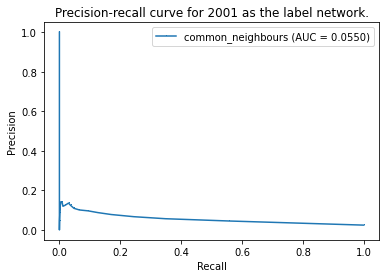

---------------
predictor: adamic_adar
P/R: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 3448 [4.769445550611524, 4.7781569437004965, 4.8711219373515755, 4.9831791387828845, 5.249051724457737, 5.29927735051873, 5.387155804162978, 5.41833584420773, 5.490672006169915, 5.566594323503102]
----------


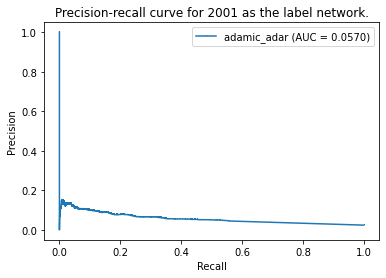

---------------
Label network year: 2002
predictor: common_neighbours
P/R: [0.4444444444444444, 0.4666666666666667, 0.38461538461538464, 0.3, 0.3333333333333333, 0.375, 0.3333333333333333, 0.3333333333333333, 0.0, 1.0] [0.0006318616223047153, 0.0005528789195166258, 0.00039491351394044705, 0.00023694810836426822, 0.00023694810836426822, 0.00023694810836426822, 0.00015796540557617883, 7.898270278808941e-05, 0.0, 0.0]
P/R Threshold: 73 [63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 71.0, 72.0, 75.0, 82.0]
----------


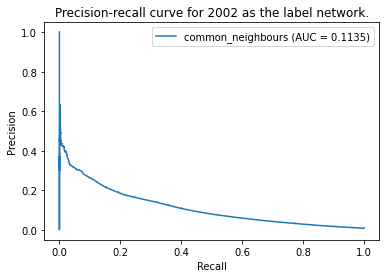

---------------
predictor: adamic_adar
P/R: [0.4444444444444444, 0.375, 0.42857142857142855, 0.5, 0.6, 0.5, 0.3333333333333333, 0.5, 0.0, 1.0] [0.00031593081115235765, 0.00023694810836426822, 0.00023694810836426822, 0.00023694810836426822, 0.00023694810836426822, 0.00015796540557617883, 7.898270278808941e-05, 7.898270278808941e-05, 0.0, 0.0]
P/R Threshold: 78223 [14.55459412949559, 14.774911200642013, 15.486068172640632, 15.728753672545219, 15.838548113424155, 15.868314614070712, 16.22096811789066, 16.315487731920374, 16.672494461820925, 18.26704193352574]
----------


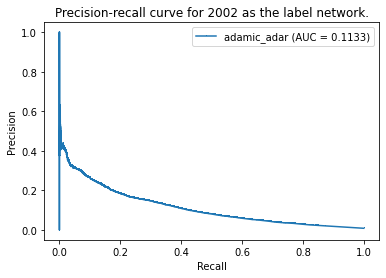

---------------
Label network year: 2003
predictor: common_neighbours
P/R: [0.8461538461538461, 0.8333333333333334, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.0009268621503201888, 0.0008426019548365353, 0.0008426019548365353, 0.0005898213683855747, 0.0005055611729019212, 0.0003370407819346141, 0.0002527805864509606, 0.00016852039096730705, 8.426019548365353e-05, 0.0]
P/R Threshold: 124 [120.0, 121.0, 122.0, 124.0, 127.0, 128.0, 131.0, 138.0, 149.0, 173.0]
----------


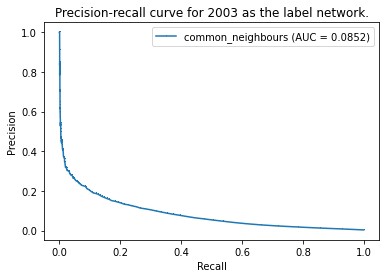

---------------
predictor: adamic_adar
P/R: [0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.0006740815638692282, 0.0006740815638692282, 0.0005898213683855747, 0.0005055611729019212, 0.00042130097741826763, 0.0003370407819346141, 0.0002527805864509606, 0.00016852039096730705, 8.426019548365353e-05, 0.0]
P/R Threshold: 236324 [25.14297862101219, 25.47136350672808, 25.59800337221245, 25.680376217627547, 25.828368884864936, 25.880232257476553, 27.053376281264622, 28.426022403547073, 29.843793958034873, 35.752040462771795]
----------


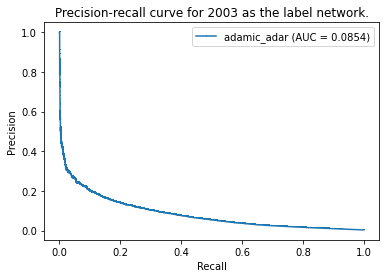

---------------
Label network year: 2004
predictor: common_neighbours
P/R: [0.6923076923076923, 0.6666666666666666, 0.7272727272727273, 0.7142857142857143, 0.6666666666666666, 0.75, 0.6666666666666666, 1.0, 1.0, 1.0] [0.0006879682005809509, 0.0006115272894052897, 0.0006115272894052897, 0.0003822045558783061, 0.00030576364470264486, 0.00022932273352698363, 0.00015288182235132243, 0.00015288182235132243, 7.644091117566121e-05, 0.0]
P/R Threshold: 156 [147.0, 148.0, 150.0, 151.0, 153.0, 154.0, 156.0, 157.0, 159.0, 164.0]
----------


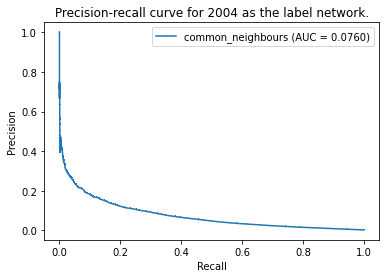

---------------
predictor: adamic_adar
P/R: [0.6666666666666666, 0.625, 0.7142857142857143, 0.6666666666666666, 0.8, 0.75, 0.6666666666666666, 0.5, 1.0, 1.0] [0.00045864546705396726, 0.0003822045558783061, 0.0003822045558783061, 0.00030576364470264486, 0.00030576364470264486, 0.00022932273352698363, 0.00015288182235132243, 7.644091117566121e-05, 7.644091117566121e-05, 0.0]
P/R Threshold: 405387 [29.057729683293196, 29.13656957502602, 29.14177591389554, 29.613864998223452, 29.67453378850127, 30.169413420406055, 30.257118399839612, 30.476891320434213, 30.626031894156608, 31.562228956364553]
----------


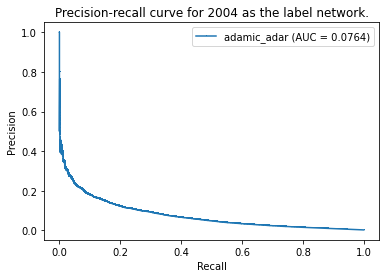

---------------
Label network year: 2005
predictor: common_neighbours
P/R: [0.5, 0.5, 0.5, 0.42857142857142855, 0.3333333333333333, 0.4, 0.25, 0.3333333333333333, 0.0, 1.0] [0.0003943736032601551, 0.0003286446693834626, 0.0002629157355067701, 0.00019718680163007755, 0.00013145786775338504, 0.00013145786775338504, 6.572893387669252e-05, 6.572893387669252e-05, 0.0, 0.0]
P/R Threshold: 185 [184.0, 186.0, 187.0, 188.0, 190.0, 193.0, 194.0, 195.0, 205.0, 209.0]
----------


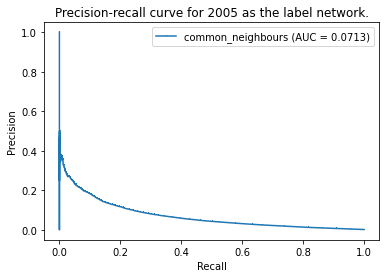

---------------
predictor: adamic_adar
P/R: [0.5555555555555556, 0.5, 0.42857142857142855, 0.3333333333333333, 0.4, 0.5, 0.3333333333333333, 0.0, 0.0, 1.0] [0.0003286446693834626, 0.0002629157355067701, 0.00019718680163007755, 0.00013145786775338504, 0.00013145786775338504, 0.00013145786775338504, 6.572893387669252e-05, 0.0, 0.0, 0.0]
P/R Threshold: 604999 [34.90273210956798, 35.23483432494119, 35.55376331384499, 35.56604943113441, 36.007758474295464, 36.40123105874967, 36.74783567480982, 38.36250488017665, 38.60615617075673, 39.38731980141181]
----------


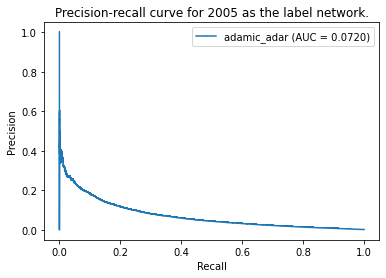

---------------
Label network year: 2006
predictor: common_neighbours
P/R: [0.4444444444444444, 0.5, 0.5714285714285714, 0.6666666666666666, 0.6, 0.5, 0.6666666666666666, 1.0, 1.0, 1.0] [0.00026743330881861334, 0.00026743330881861334, 0.00026743330881861334, 0.00026743330881861334, 0.00020057498161396003, 0.00013371665440930667, 0.00013371665440930667, 0.00013371665440930667, 6.685832720465334e-05, 0.0]
P/R Threshold: 223 [221.0, 222.0, 223.0, 231.0, 232.0, 234.0, 235.0, 236.0, 237.0, 250.0]
----------


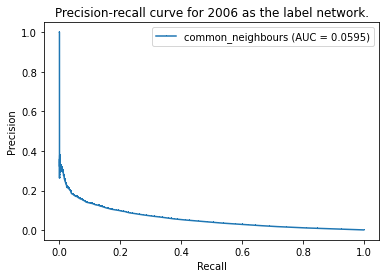

---------------
predictor: adamic_adar
P/R: [0.4444444444444444, 0.5, 0.5714285714285714, 0.6666666666666666, 0.6, 0.5, 0.3333333333333333, 0.5, 1.0, 1.0] [0.00026743330881861334, 0.00026743330881861334, 0.00026743330881861334, 0.00026743330881861334, 0.00020057498161396003, 0.00013371665440930667, 6.685832720465334e-05, 6.685832720465334e-05, 6.685832720465334e-05, 0.0]
P/R Threshold: 855897 [40.89086544290077, 40.995527938149344, 41.06348074494491, 42.342150511645265, 42.483455759509006, 42.485705541606166, 43.24381399028291, 43.41823105839092, 43.55836720097231, 46.119457148799455]
----------


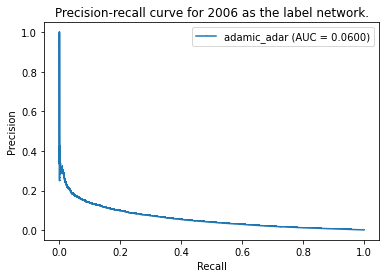

---------------
Label network year: 2007
predictor: common_neighbours
P/R: [0.125, 0.16666666666666666, 0.18181818181818182, 0.2, 0.125, 0.2, 0.25, 0.5, 0.0, 1.0] [0.0003781433163168841, 0.0003781433163168841, 0.0003781433163168841, 0.0003781433163168841, 0.00018907165815844205, 0.00018907165815844205, 0.00018907165815844205, 0.00018907165815844205, 0.0, 0.0]
P/R Threshold: 248 [246.0, 247.0, 248.0, 252.0, 253.0, 254.0, 256.0, 259.0, 270.0, 275.0]
----------


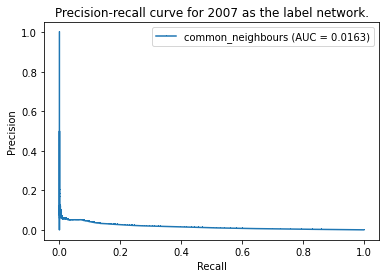

---------------
predictor: adamic_adar
P/R: [0.2222222222222222, 0.125, 0.14285714285714285, 0.16666666666666666, 0.2, 0.25, 0.3333333333333333, 0.5, 1.0, 1.0] [0.0003781433163168841, 0.00018907165815844205, 0.00018907165815844205, 0.00018907165815844205, 0.00018907165815844205, 0.00018907165815844205, 0.00018907165815844205, 0.00018907165815844205, 0.00018907165815844205, 0.0]
P/R Threshold: 1114852 [45.322974368375945, 45.999137233365914, 46.06210413536311, 46.244505209457216, 46.501757284595975, 46.50408246523552, 47.063019812135465, 47.261631658640944, 49.706399340521386, 49.812958644195554]
----------


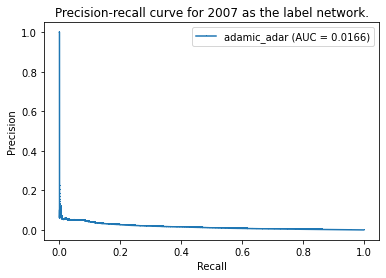

---------------
Label network year: 2008
predictor: common_neighbours
P/R: [0.13333333333333333, 0.07142857142857142, 0.1, 0.1111111111111111, 0.16666666666666666, 0.2, 0.25, 0.3333333333333333, 1.0, 1.0] [0.0001265022137887413, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 0.0]
P/R Threshold: 255 [253.0, 255.0, 258.0, 260.0, 261.0, 262.0, 264.0, 266.0, 269.0, 285.0]
----------


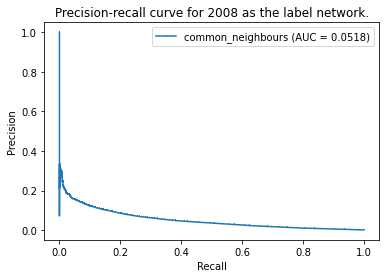

---------------
predictor: adamic_adar
P/R: [0.1111111111111111, 0.125, 0.14285714285714285, 0.16666666666666666, 0.2, 0.25, 0.3333333333333333, 0.5, 1.0, 1.0] [6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 6.325110689437066e-05, 0.0]
P/R Threshold: 1204045 [46.51725830790146, 46.78545605417728, 47.00348231146503, 47.36451224027238, 47.563522433688725, 47.955679755866946, 47.959792634842, 48.22425355120845, 48.73039021701399, 51.052920482486]
----------


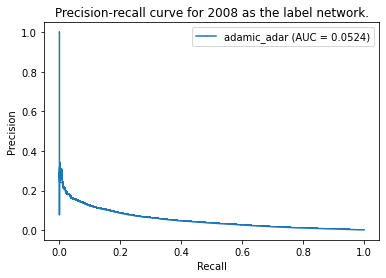

---------------
Label network year: 2009
predictor: common_neighbours
P/R: [0.5, 0.4444444444444444, 0.375, 0.2857142857142857, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 1.0, 1.0] [0.00029448141822251015, 0.00023558513457800812, 0.0001766888509335061, 0.00011779256728900406, 0.00011779256728900406, 0.00011779256728900406, 5.889628364450203e-05, 5.889628364450203e-05, 5.889628364450203e-05, 0.0]
P/R Threshold: 284 [289.0, 292.0, 296.0, 297.0, 299.0, 302.0, 303.0, 304.0, 307.0, 314.0]
----------


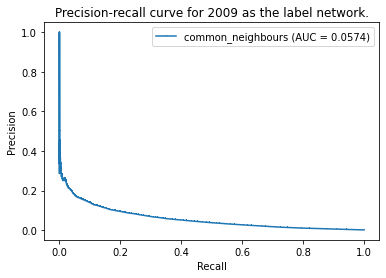

---------------
predictor: adamic_adar
P/R: [0.4444444444444444, 0.375, 0.2857142857142857, 0.3333333333333333, 0.4, 0.5, 0.3333333333333333, 0.5, 1.0, 1.0] [0.00023558513457800812, 0.0001766888509335061, 0.00011779256728900406, 0.00011779256728900406, 0.00011779256728900406, 0.00011779256728900406, 5.889628364450203e-05, 5.889628364450203e-05, 5.889628364450203e-05, 0.0]
P/R Threshold: 1490791 [51.10560954197312, 52.37337857417731, 53.20413178377848, 53.45838389123095, 53.71579683611125, 53.89577305114081, 54.0518713987756, 54.3369016567762, 54.74899959063495, 55.81544461628265]
----------


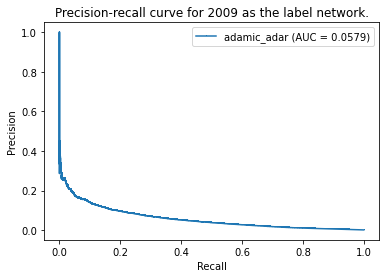

---------------
Label network year: 2010
predictor: common_neighbours
P/R: [0.36363636363636365, 0.4444444444444444, 0.5, 0.42857142857142855, 0.6, 0.5, 0.6666666666666666, 0.5, 1.0, 1.0] [0.0002595211834165964, 0.0002595211834165964, 0.0002595211834165964, 0.00019464088756244728, 0.00019464088756244728, 0.0001297605917082982, 0.0001297605917082982, 6.48802958541491e-05, 6.48802958541491e-05, 0.0]
P/R Threshold: 307 [314.0, 316.0, 320.0, 324.0, 330.0, 332.0, 344.0, 346.0, 351.0, 354.0]
----------


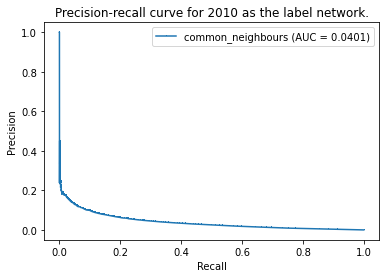

---------------
predictor: adamic_adar
P/R: [0.4444444444444444, 0.375, 0.42857142857142855, 0.5, 0.6, 0.5, 0.6666666666666666, 0.5, 1.0, 1.0] [0.0002595211834165964, 0.00019464088756244728, 0.00019464088756244728, 0.00019464088756244728, 0.00019464088756244728, 0.0001297605917082982, 0.0001297605917082982, 6.48802958541491e-05, 6.48802958541491e-05, 0.0]
P/R Threshold: 1821873 [55.178370998045, 55.86990808100784, 56.05592223315464, 57.37019528448581, 57.87123568553472, 58.31324996412517, 61.22021858771335, 61.25277665870559, 61.64129464185414, 63.49512513775922]
----------


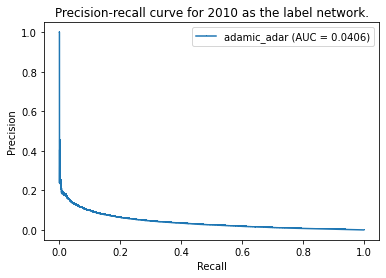

---------------
Label network year: 2011
predictor: common_neighbours
P/R: [0.18181818181818182, 0.2, 0.25, 0.14285714285714285, 0.16666666666666666, 0.2, 0.0, 0.0, 0.0, 1.0] [0.00016385384237260363, 0.00016385384237260363, 0.00016385384237260363, 8.192692118630181e-05, 8.192692118630181e-05, 8.192692118630181e-05, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 329 [336.0, 337.0, 339.0, 340.0, 341.0, 342.0, 348.0, 364.0, 367.0, 377.0]
----------


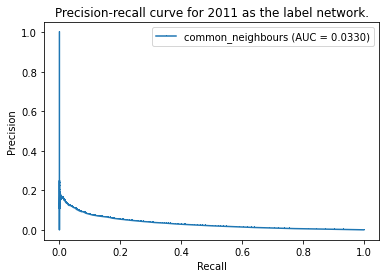

---------------
predictor: adamic_adar
P/R: [0.2, 0.2222222222222222, 0.25, 0.3333333333333333, 0.2, 0.0, 0.0, 0.0, 0.0, 1.0] [0.00016385384237260363, 0.00016385384237260363, 0.00016385384237260363, 0.00016385384237260363, 8.192692118630181e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 2144854 [58.12298615565186, 58.63779665404949, 58.80389165553394, 58.89651822690849, 59.698912926039, 60.228382173676366, 63.384358471025564, 64.68341860820861, 65.35336383729704, 65.84053169390629]
----------


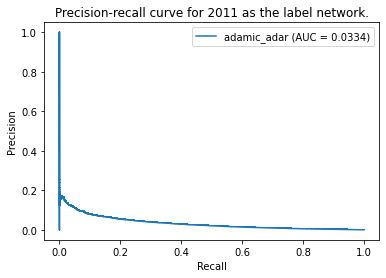

---------------
Label network year: 2012
predictor: common_neighbours
P/R: [0.21428571428571427, 0.23076923076923078, 0.2, 0.2857142857142857, 0.3333333333333333, 0.4, 0.25, 0.3333333333333333, 0.5, 1.0] [0.0001585288522511097, 0.0001585288522511097, 0.0001056859015007398, 0.0001056859015007398, 0.0001056859015007398, 0.0001056859015007398, 5.28429507503699e-05, 5.28429507503699e-05, 5.28429507503699e-05, 0.0]
P/R Threshold: 352 [352.0, 353.0, 355.0, 357.0, 359.0, 365.0, 375.0, 384.0, 400.0, 404.0]
----------


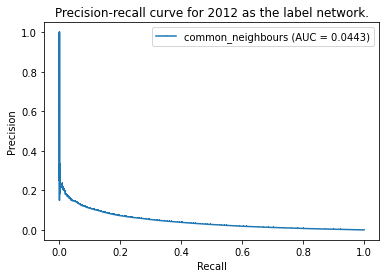

---------------
predictor: adamic_adar
P/R: [0.18181818181818182, 0.2, 0.25, 0.3333333333333333, 0.4, 0.25, 0.3333333333333333, 0.0, 0.0, 1.0] [0.0001056859015007398, 0.0001056859015007398, 0.0001056859015007398, 0.0001056859015007398, 0.0001056859015007398, 5.28429507503699e-05, 5.28429507503699e-05, 0.0, 0.0, 0.0]
P/R Threshold: 2421935 [61.19731126309327, 61.19917667172825, 61.43378663513727, 61.496470653759545, 62.73715515720291, 64.09089964858828, 66.43316569790298, 69.35265702982517, 69.54149669174357, 71.2088655649625]
----------


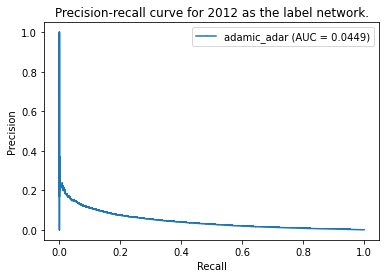

---------------
Label network year: 2013
predictor: common_neighbours
P/R: [0.45454545454545453, 0.4, 0.4444444444444444, 0.5714285714285714, 0.5, 0.75, 0.6666666666666666, 1.0, 1.0, 1.0] [0.00029190262128553915, 0.00023352209702843133, 0.00023352209702843133, 0.00023352209702843133, 0.00017514157277132348, 0.00017514157277132348, 0.00011676104851421566, 0.00011676104851421566, 5.838052425710783e-05, 0.0]
P/R Threshold: 379 [383.0, 384.0, 385.0, 396.0, 397.0, 399.0, 405.0, 407.0, 435.0, 441.0]
----------


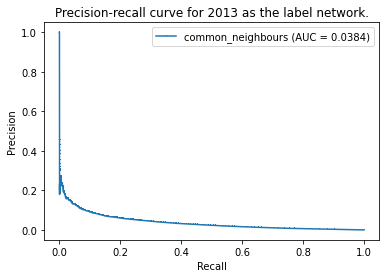

---------------
predictor: adamic_adar
P/R: [0.36363636363636365, 0.4, 0.4444444444444444, 0.375, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0] [0.00023352209702843133, 0.00023352209702843133, 0.00023352209702843133, 0.00017514157277132348, 0.00017514157277132348, 0.00017514157277132348, 0.00017514157277132348, 0.00011676104851421566, 5.838052425710783e-05, 0.0]
P/R Threshold: 2856066 [65.13726028255716, 65.17980312005257, 65.30672891952571, 66.7885762571649, 68.06929038892294, 68.4216559404555, 69.28032000310354, 69.32516082207412, 75.30247906718307, 76.75710961930517]
----------


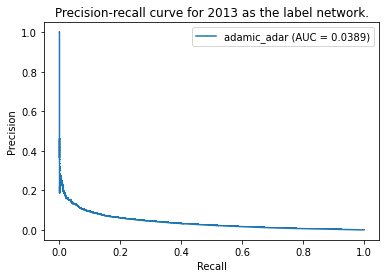

---------------
Label network year: 2014
predictor: common_neighbours
P/R: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 398 [402.0, 404.0, 405.0, 412.0, 415.0, 421.0, 424.0, 425.0, 429.0, 431.0]
----------


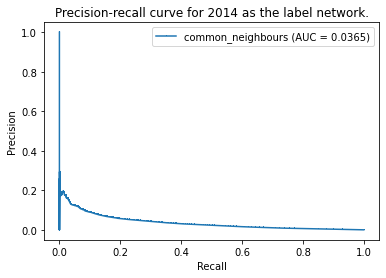

---------------
predictor: adamic_adar
P/R: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 3271562 [67.80735425258982, 68.05111424198991, 69.197706664801, 69.68311923330624, 70.47014593617074, 71.583370753646, 72.48569282805768, 72.77188912129172, 72.82688848588904, 73.34937644132756]
----------


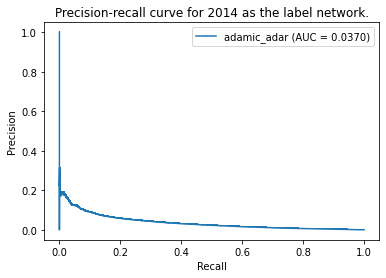

---------------
Label network year: 2015
predictor: common_neighbours
P/R: [0.35714285714285715, 0.3076923076923077, 0.25, 0.1, 0.125, 0.14285714285714285, 0.3333333333333333, 0.5, 1.0, 1.0] [0.0002990430622009569, 0.00023923444976076556, 0.00017942583732057416, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 0.0]
P/R Threshold: 426 [430.0, 431.0, 441.0, 446.0, 448.0, 452.0, 457.0, 458.0, 460.0, 481.0]
----------


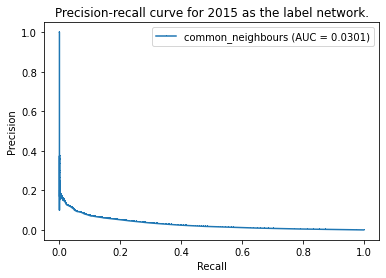

---------------
predictor: adamic_adar
P/R: [0.3076923076923077, 0.25, 0.1, 0.1111111111111111, 0.14285714285714285, 0.2, 0.3333333333333333, 0.5, 1.0, 1.0] [0.00023923444976076556, 0.00017942583732057416, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 5.980861244019139e-05, 0.0]
P/R Threshold: 3747017 [72.66587583755695, 73.45399509353972, 75.5581050584221, 76.09401955698894, 76.16196424650843, 76.64109266640163, 77.11262475751383, 77.12240252060298, 77.2495939921164, 82.90118603455218]
----------


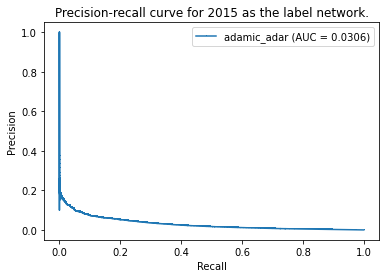

---------------
Label network year: 2016
predictor: common_neighbours
P/R: [0.23076923076923078, 0.2727272727272727, 0.3, 0.375, 0.2857142857142857, 0.3333333333333333, 0.4, 0.0, 0.0, 1.0] [0.00020347259902333151, 0.00020347259902333151, 0.00020347259902333151, 0.00020347259902333151, 0.00013564839934888768, 0.00013564839934888768, 0.00013564839934888768, 0.0, 0.0, 0.0]
P/R Threshold: 437 [461.0, 462.0, 464.0, 469.0, 471.0, 473.0, 488.0, 496.0, 504.0, 507.0]
----------


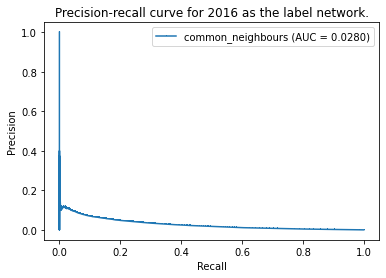

---------------
predictor: adamic_adar
P/R: [0.2727272727272727, 0.3, 0.3333333333333333, 0.375, 0.42857142857142855, 0.3333333333333333, 0.4, 0.0, 0.0, 1.0] [0.00020347259902333151, 0.00020347259902333151, 0.00020347259902333151, 0.00020347259902333151, 0.00020347259902333151, 0.00013564839934888768, 0.00013564839934888768, 0.0, 0.0, 0.0]
P/R Threshold: 4202481 [77.37953573078666, 77.68190981160109, 79.12846465090443, 79.1447652873897, 79.14476528738973, 79.16979492976043, 81.94220875520021, 83.75528184112574, 84.69685100393585, 85.17374211549576]
----------


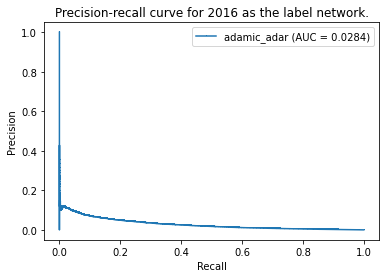

---------------
Label network year: 2017
predictor: common_neighbours
P/R: [0.08333333333333333, 0.09090909090909091, 0.1, 0.125, 0.16666666666666666, 0.2, 0.25, 0.0, 0.0, 1.0] [8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 0.0, 0.0, 0.0]
P/R Threshold: 455 [461.0, 468.0, 477.0, 481.0, 487.0, 489.0, 502.0, 506.0, 540.0, 543.0]
----------


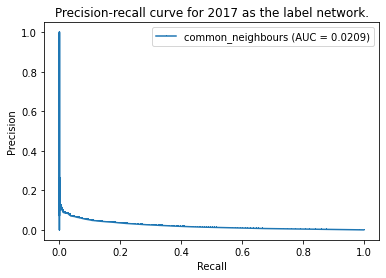

---------------
predictor: adamic_adar
P/R: [0.08333333333333333, 0.09090909090909091, 0.1, 0.125, 0.16666666666666666, 0.2, 0.25, 0.0, 0.0, 1.0] [8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 8.41467519353753e-05, 0.0, 0.0, 0.0]
P/R Threshold: 4592908 [77.55184053148798, 78.13036753933177, 80.32732327085236, 80.7717462043691, 81.85489692562027, 82.15601174640143, 83.82894769998249, 84.48845540424779, 90.56481855042664, 91.03740459064598]
----------


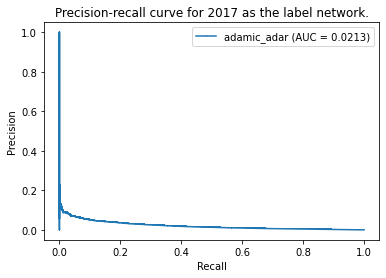

---------------
Label network year: 2018
predictor: common_neighbours
P/R: [0.15384615384615385, 0.16666666666666666, 0.2222222222222222, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] [0.00013932427725531175, 0.00013932427725531175, 0.00013932427725531175, 6.966213862765588e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 472 [480.0, 482.0, 485.0, 494.0, 499.0, 513.0, 515.0, 528.0, 561.0, 564.0]
----------


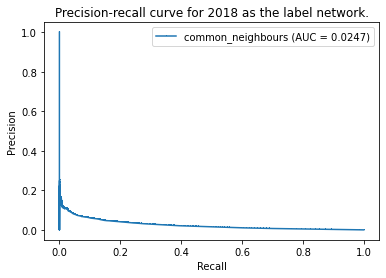

---------------
predictor: adamic_adar
P/R: [0.16666666666666666, 0.18181818181818182, 0.2222222222222222, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] [0.00013932427725531175, 0.00013932427725531175, 0.00013932427725531175, 6.966213862765588e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 4892650 [79.88834355458783, 80.32127716997864, 81.03865981680264, 81.71586972281872, 84.18851458588114, 86.16690648270094, 86.46720977181087, 88.10791821909118, 94.08196546189535, 94.55240229173025]
----------


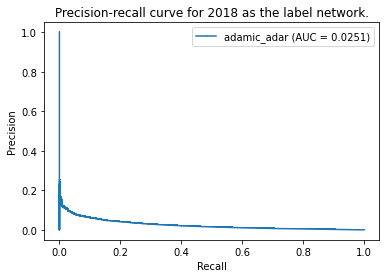

---------------
Label network year: 2019
predictor: common_neighbours
P/R: [0.21428571428571427, 0.23076923076923078, 0.3, 0.375, 0.42857142857142855, 0.2, 0.0, 0.0, 0.0, 1.0] [0.00037290242386575515, 0.00037290242386575515, 0.00037290242386575515, 0.00037290242386575515, 0.00037290242386575515, 0.0001243008079552517, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 485 [494.0, 496.0, 497.0, 502.0, 511.0, 536.0, 538.0, 545.0, 583.0, 587.0]
----------


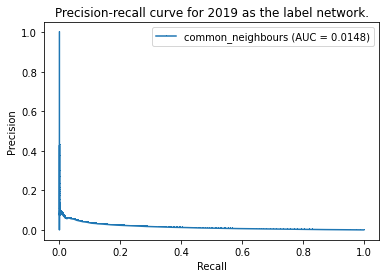

---------------
predictor: adamic_adar
P/R: [0.25, 0.3, 0.3333333333333333, 0.375, 0.42857142857142855, 0.2, 0.0, 0.0, 0.0, 1.0] [0.00037290242386575515, 0.00037290242386575515, 0.00037290242386575515, 0.00037290242386575515, 0.00037290242386575515, 0.0001243008079552517, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 5242710 [82.21335016460775, 82.53897510066464, 82.70209665409334, 83.83531135402563, 84.51340571179773, 89.61602884089734, 89.9147510508539, 90.37339497591138, 97.70277326373203, 98.36723151061047]
----------


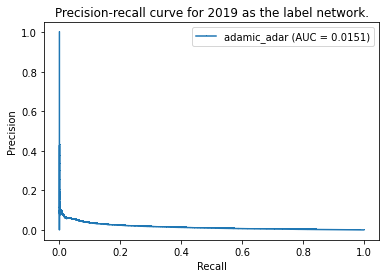

---------------
Label network year: 2020
predictor: common_neighbours
P/R: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 489 [503.0, 504.0, 505.0, 506.0, 512.0, 518.0, 528.0, 552.0, 598.0, 602.0]
----------


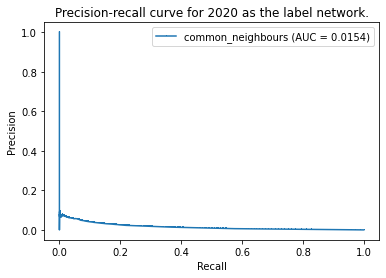

---------------
predictor: adamic_adar
P/R: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P/R Threshold: 5450625 [82.99602812523956, 83.13624356130113, 83.317995055701, 83.8777038826169, 84.02867186167015, 86.43389638389039, 87.29855326563748, 91.18125934948773, 100.09975894156922, 100.76215797092547]
----------


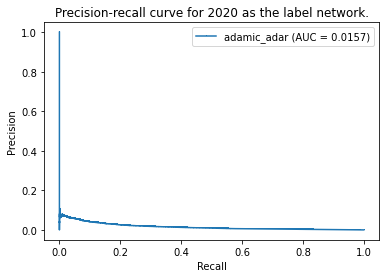

---------------


In [74]:
for t in range(2000,2020):
    print("Label network year:",t+1)
    record_t = raw_records.get(str(t))
    
#     pyplot.figure(figsize=(10, 8), dpi=300)
    
    # only look at the CN predictor
#     i = 3

    for i in range(4):
        if i == 0 or i == 2:
            name,prc,roc = record_t[i][0],record_t[i][2],record_t[i][1]
            prec,rec,pr_thre,pr_auc = prc[1][0],prc[1][1],prc[1][2],prc[0]
            fpr,tpr,roc_thre,roc_auc = roc[1][0],roc[1][1],roc[1][2],roc[0]
            print("predictor:",name)
            print("P/R:",prec[-10:],rec[-10:])
            print("P/R Threshold:",len(pr_thre),pr_thre[-10:])
#             print("fpr/tpr:",fpr[:10],tpr[:10])
#             print("fpr/tpr Threshold:",len(roc_thre),roc_thre[:10])
#             print("AUROC:",roc_auc)
            print("----------")

            ## precision-recall curve, ignore the last point when P-R is [1.0,0.0],
            ## this is only used to ensure the curve is on the y-axis, it doesn't have a threshold
            ## however, doing this will change the scale of the y-axis
            pyplot.plot(rec, prec, marker=',', label=name+' (AUC = %0.4f)' % pr_auc)   #  if t == 2019, the label network is 2020-2021

            # axis labels
            pyplot.xlabel('Recall')
            pyplot.ylabel('Precision')
            # show the legend
            pyplot.legend()
            # show the plot
            pyplot.title("Precision-recall curve for {} as the label network.".format(t+1))
        #     pyplot.savefig(save_plot+"Precision-recall curve for {} as the label network.".format(t+1))
            pyplot.show()

#             ## roc curve, be fair to the pr curve, ignore the last point when P-R is [0.0,0.0],
#             ## however, doing this will change the scale of the y-axis
#             pyplot.plot(fpr, tpr, marker=',', label=name+' (AUC = %0.4f)' % roc_auc)

#             # axis labels
#             pyplot.xlabel('False positive rate')
#             pyplot.ylabel('True positive rate')
#             # show the legend
#             pyplot.legend()
#             # show the plot
#             pyplot.title("ROC curve for {} as the label network.".format(t+1))
#         #     pyplot.savefig(save_plot+"ROC curve for {} as the label network.".format(t+1))
#             pyplot.show()
            print("---------------")  

    
    

Label network year: 2001


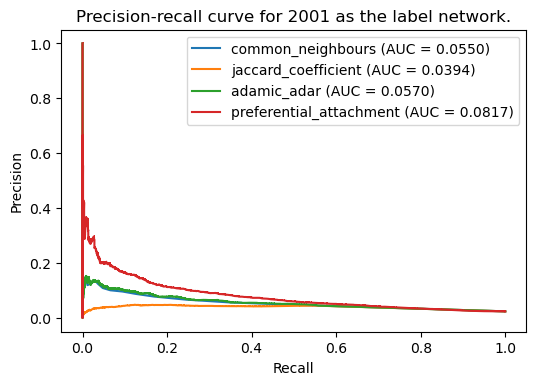

---------------


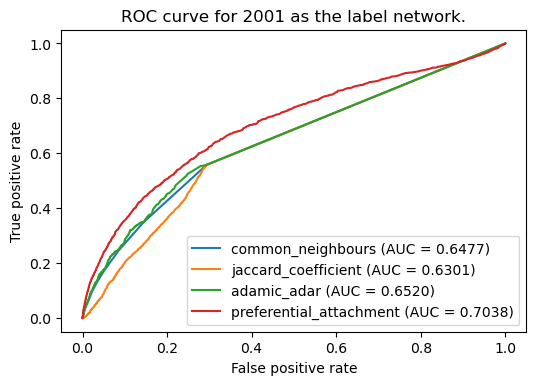

---------------
------------------------------
Label network year: 2002


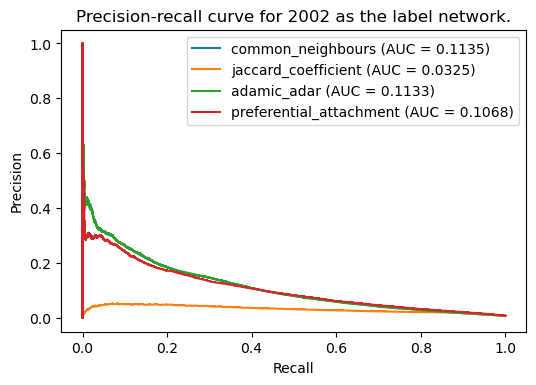

---------------


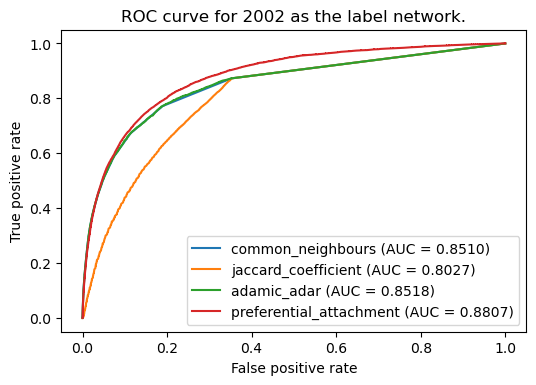

---------------
------------------------------
Label network year: 2003


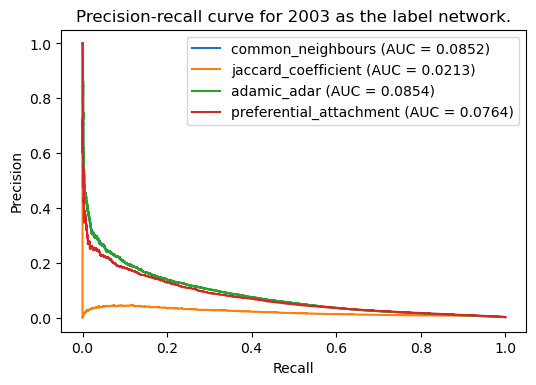

---------------


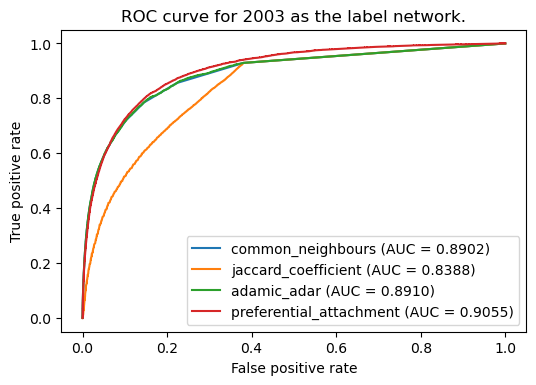

---------------
------------------------------
Label network year: 2004


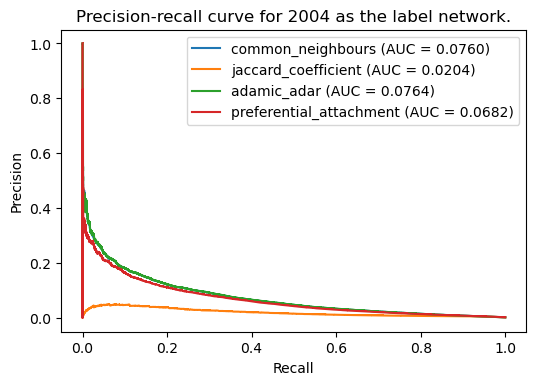

---------------


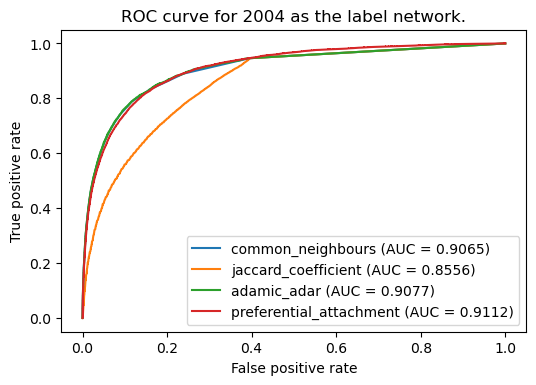

---------------
------------------------------
Label network year: 2005


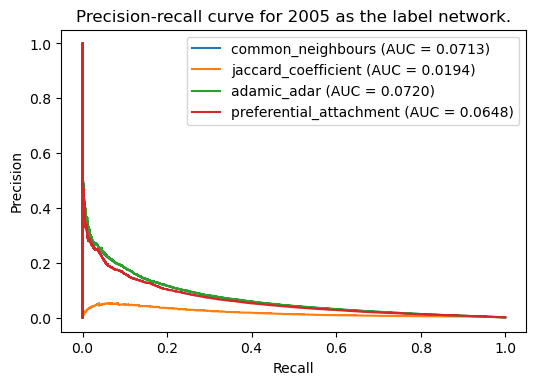

---------------


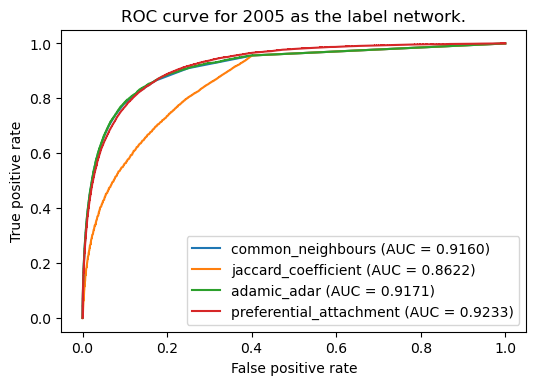

---------------
------------------------------
Label network year: 2006


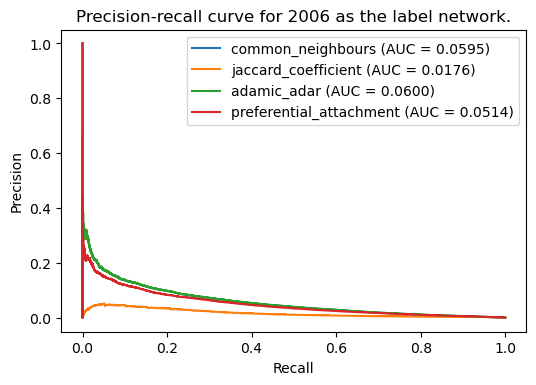

---------------


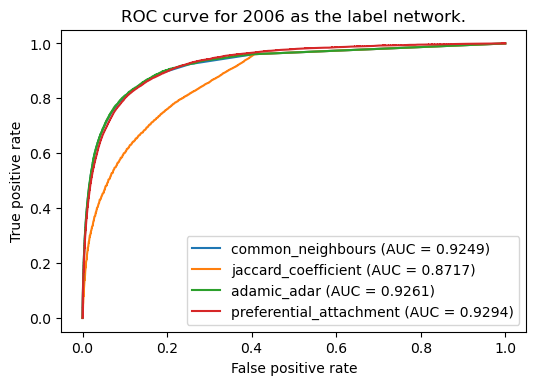

---------------
------------------------------
Label network year: 2007


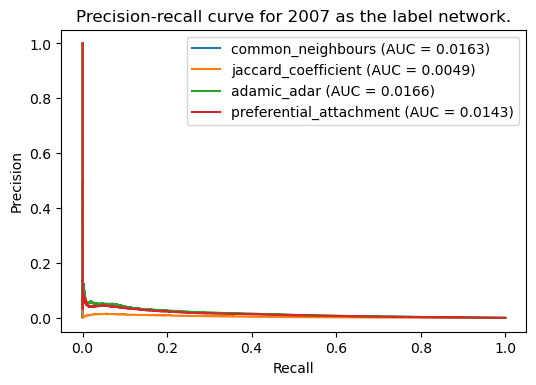

---------------


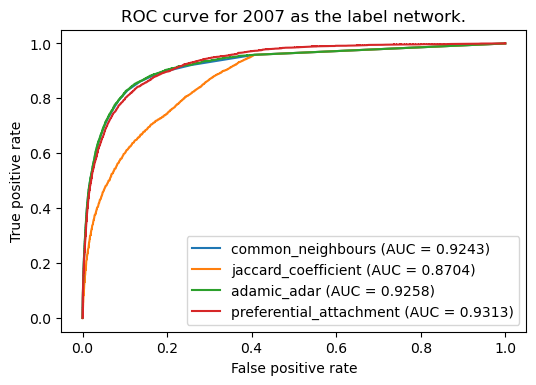

---------------
------------------------------
Label network year: 2008


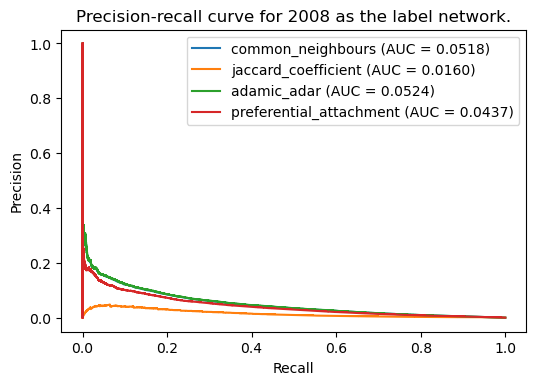

---------------


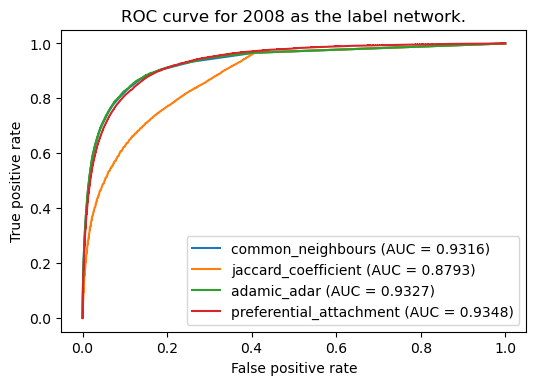

---------------
------------------------------
Label network year: 2009


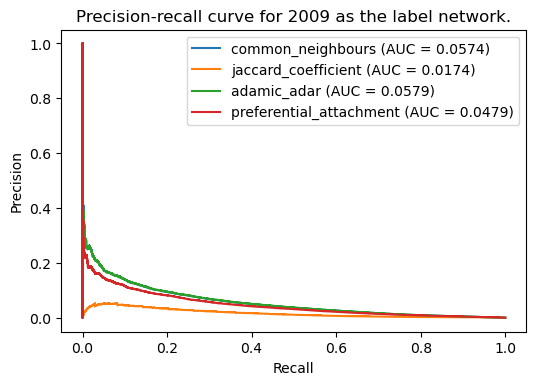

---------------


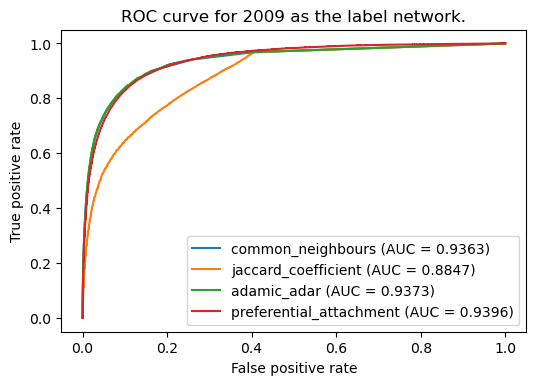

---------------
------------------------------
Label network year: 2010


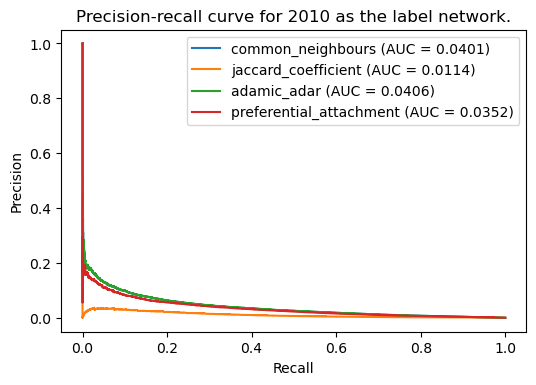

---------------


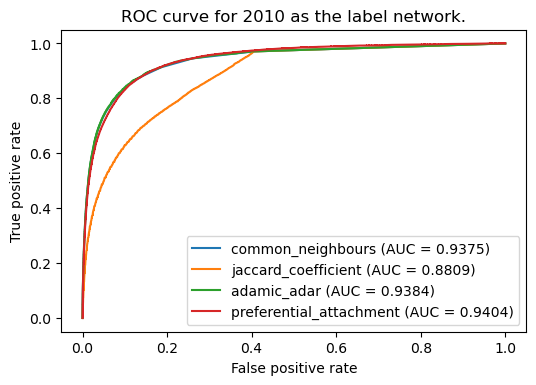

---------------
------------------------------
Label network year: 2011


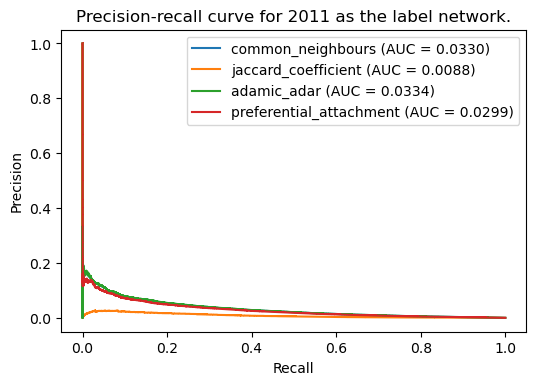

---------------


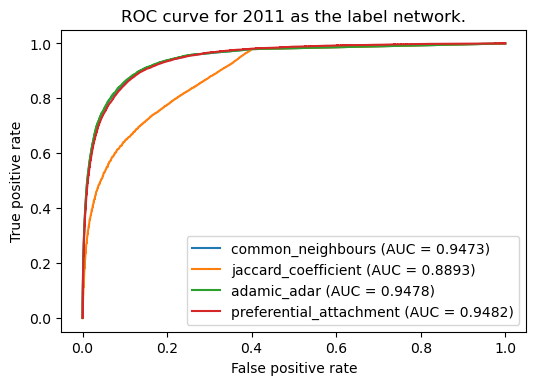

---------------
------------------------------
Label network year: 2012


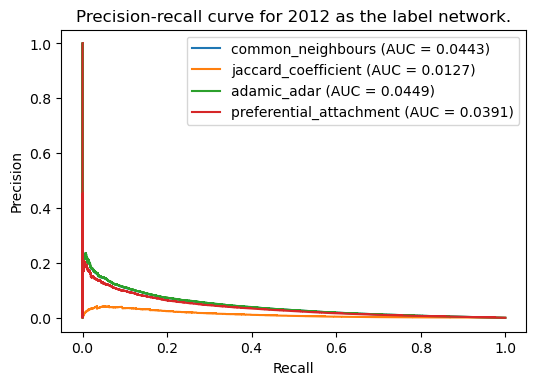

---------------


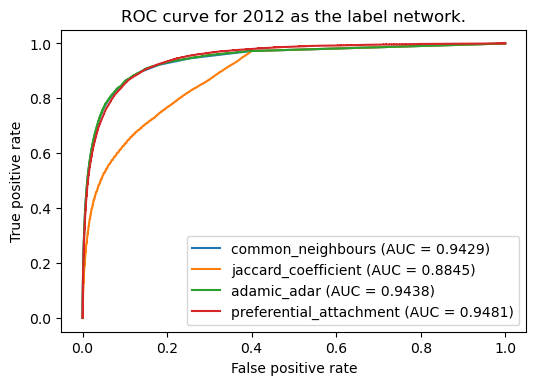

---------------
------------------------------
Label network year: 2013


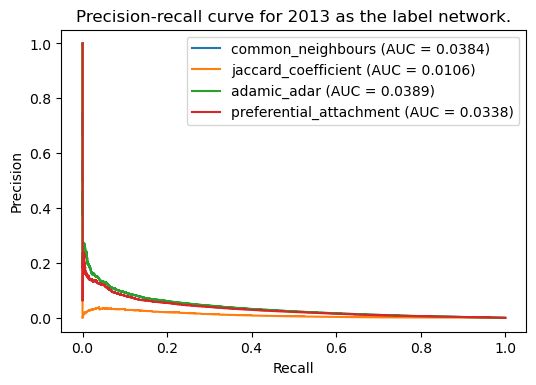

---------------


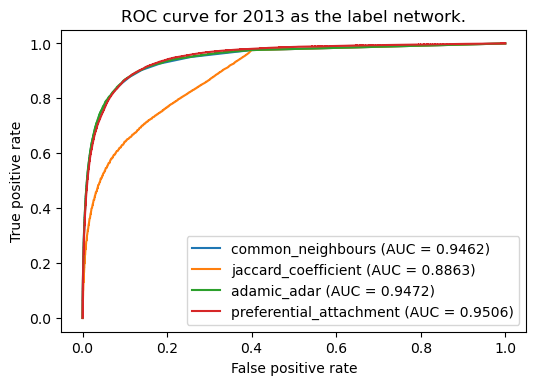

---------------
------------------------------
Label network year: 2014


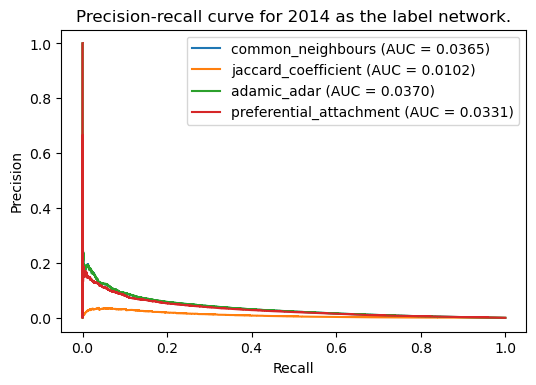

---------------


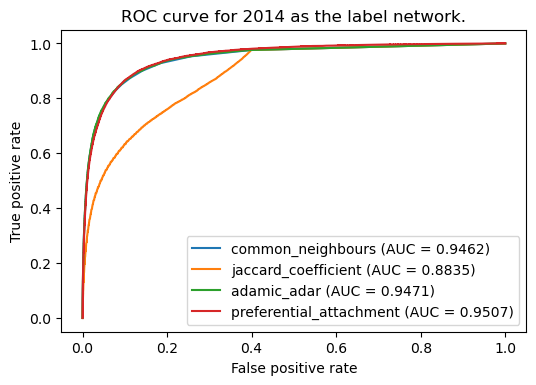

---------------
------------------------------
Label network year: 2015


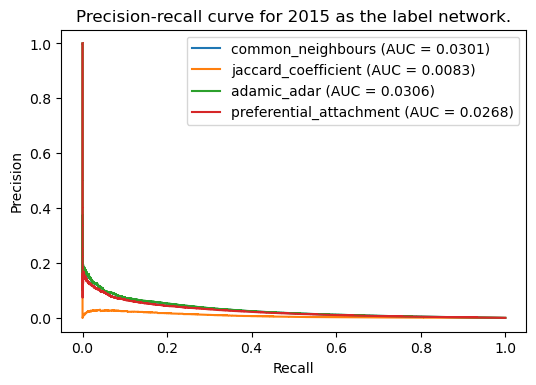

---------------


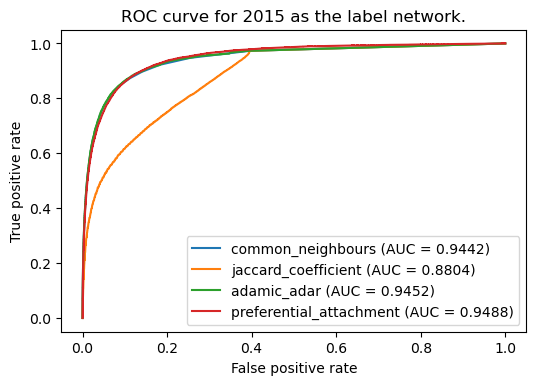

---------------
------------------------------
Label network year: 2016


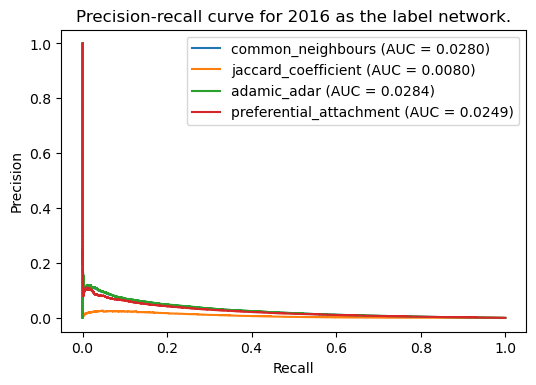

---------------


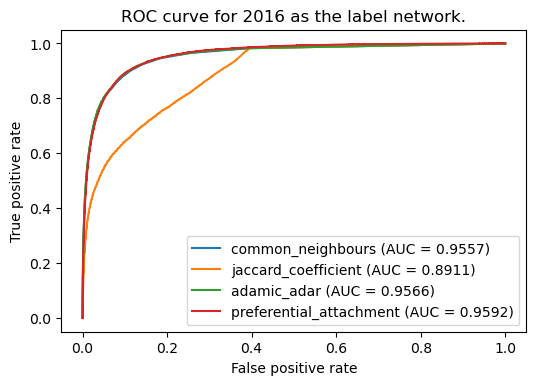

---------------
------------------------------
Label network year: 2017


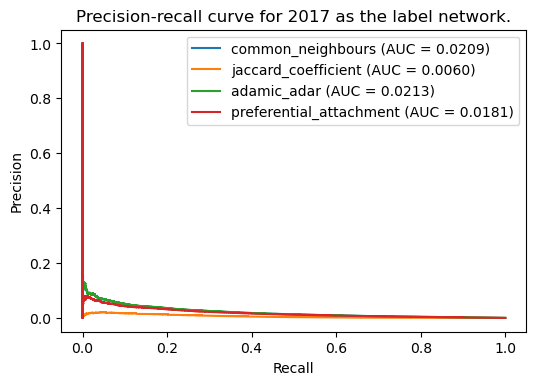

---------------


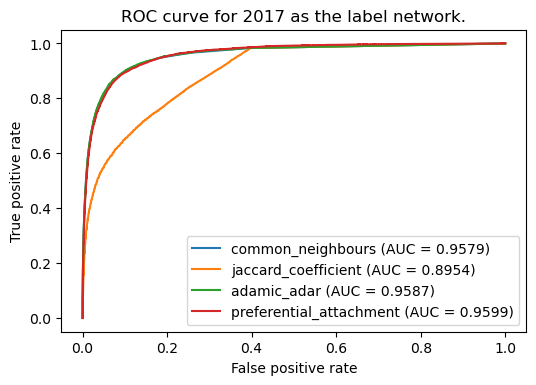

---------------
------------------------------
Label network year: 2018


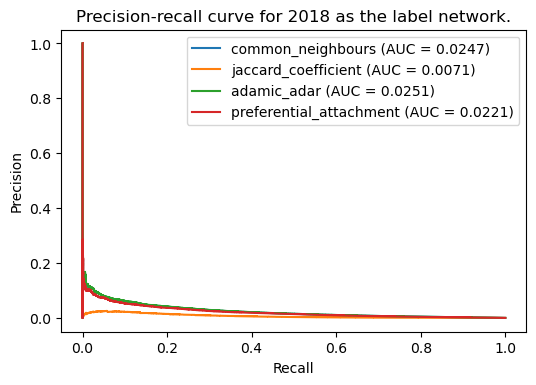

---------------


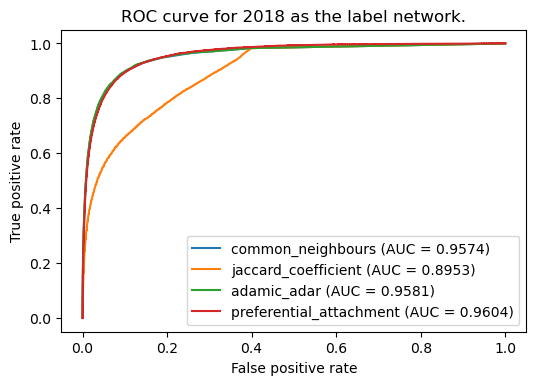

---------------
------------------------------
Label network year: 2019


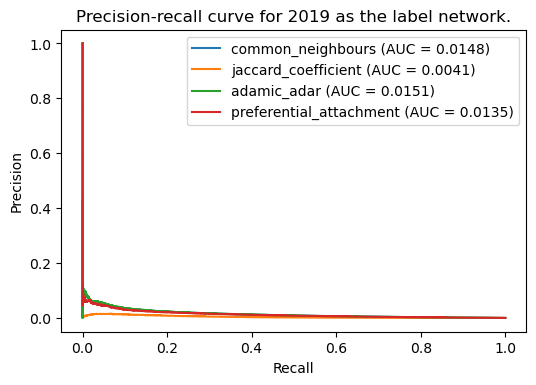

---------------


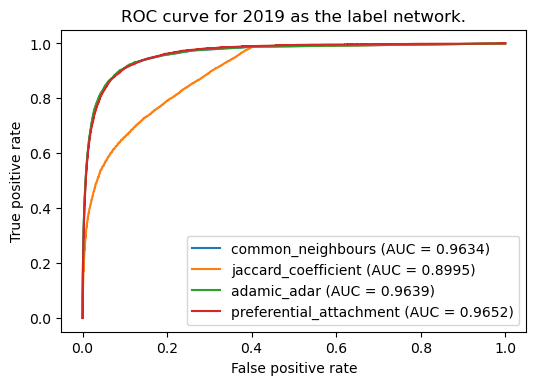

---------------
------------------------------
Label network year: 2020


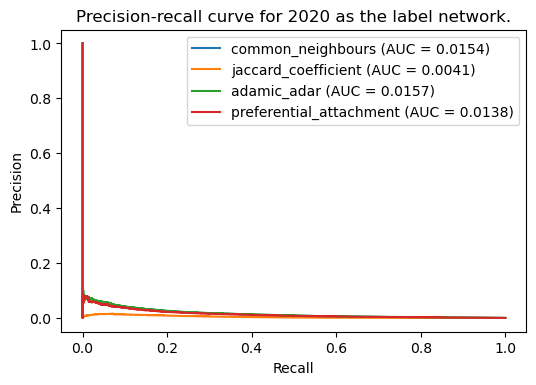

---------------


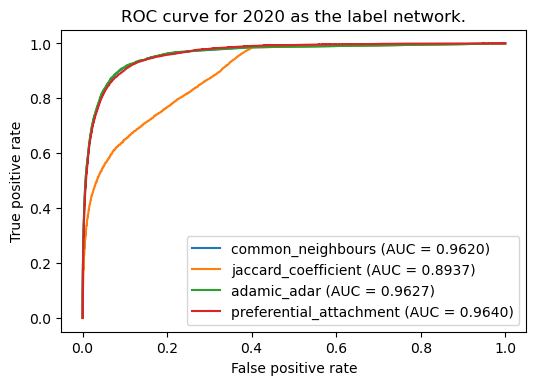

---------------
------------------------------


In [73]:
save_plot = "/Users/yidesdo21/Projects/outputs/15_roc_pr_plots/"

for t in range(2000,2020):
    print("Label network year:",t+1)
    record_t = raw_records.get(str(t))
    
    pyplot.figure(figsize=(6, 4), dpi=100)
    
    for i in range(4):
        name,prc,roc = record_t[i][0],record_t[i][2],record_t[i][1]
        prec,rec,pr_thre,pr_auc = prc[1][0],prc[1][1],prc[1][2],prc[0]
        
        ## precision-recall curve
        
        pyplot.plot(rec, prec, marker=',', label=name+' (AUC = %0.4f)' % pr_auc)   #  if t == 2019, the label network is 2020-2021
        
        
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.title("Precision-recall curve for {} as the label network.".format(t+1))
#     pyplot.savefig(save_plot+"Precision-recall curve for {} as the label network.".format(t+1))
    pyplot.show()
    
    print("---------------")
    
    pyplot.figure(figsize=(6, 4), dpi=100)
    for i in range(4):
        name,prc,roc = record_t[i][0],record_t[i][2],record_t[i][1]
        fpr,tpr,roc_thre,roc_auc = roc[1][0],roc[1][1],roc[1][2],roc[0]
        
        ## roc curve
        pyplot.plot(fpr, tpr, marker=',', label=name+' (AUC = %0.4f)' % roc_auc)
        
    
    # axis labels
    pyplot.xlabel('False positive rate')
    pyplot.ylabel('True positive rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.title("ROC curve for {} as the label network.".format(t+1))
#     pyplot.savefig(save_plot+"ROC curve for {} as the label network.".format(t+1))
    pyplot.show()
    print("---------------")  
    print("------------------------------")  
        
#     break

In [67]:
# {year:[number of fixed nodes, positive links in the feature network
#.     positive links in the label network, negative links in the feature network before undersampling,
#.     [(model1,auroc,auprc),
#.      (model2,auroc,auprc),...]]}
# year_records

In [68]:
## turn the records into a dataframe
## expected df -- year,#fixed nodes,#links_fea_net,#links_lab_net,#neg_fea_net,
##                cn_auroc,cn_auprc,jc_auroc,jc_auprc,pa_auroc,pa_auprc,aa_auroc,aa_auprc  
num_nodes_lst,num_links_fea_net_lst,num_links_lab_net_lst,num_neg_fea_net_lst = list(),list(),list(),list()
cn_auroc_lst,cn_auprc_lst,jc_auroc_lst,jc_auprc_lst = list(),list(),list(),list()
pa_auroc_lst,pa_auprc_lst,aa_auroc_lst,aa_auprc_lst = list(),list(),list(),list()
predictor,auroc_lst,auprc_lst = list(),list(),list()
years = list()

for year,values in year_records.items():
#     print(values[0])
    ## if opening the data with sampling, need to turn into values[0][0]...
    
    num_nodes,num_links_fea_net,num_links_lab_net,num_neg_fea_net,\
    cn_auroc,cn_auprc,jc_auroc,jc_auprc,\
    aa_auroc,aa_auprc,pa_auroc,pa_auprc = values[0],values[1],values[2],values[3],\
                                          values[4][0][1],values[4][0][2],\
                                          values[4][1][1],values[4][1][2],\
                                          values[4][2][1],values[4][2][2],\
                                          values[4][3][1],values[4][3][2]
    
    cn_predictor,jc_predictor,aa_predictor,pa_predictor = values[4][0][0],values[4][1][0],\
                                                            values[4][2][0],values[4][3][0]
#     num_nodes_lst += 4*[num_nodes]
#     num_links_fea_net_lst += 4*[num_links_fea_net]
#     num_links_lab_net_lst += 4*[num_links_lab_net]
#     num_neg_fea_net_lst += 4*[num_neg_fea_net]
    num_nodes_lst.append(num_nodes)
    num_links_fea_net_lst.append(num_links_fea_net)
    num_links_lab_net_lst.append(num_links_lab_net)
    num_neg_fea_net_lst.append(num_neg_fea_net)
#     predictor.extend([cn_predictor,jc_predictor,aa_predictor,pa_predictor])
#     years += 4*[year]
#     auroc_lst.extend([cn_auroc,jc_auroc,aa_auroc,pa_auroc])
#     auprc_lst.extend([cn_auprc,jc_auprc,aa_auprc,pa_auprc])
    cn_auroc_lst.append(cn_auroc)
    cn_auprc_lst.append(cn_auprc)
    jc_auroc_lst.append(jc_auroc)
    jc_auprc_lst.append(jc_auprc)
    pa_auroc_lst.append(pa_auroc)
    pa_auprc_lst.append(pa_auprc)
    aa_auroc_lst.append(aa_auroc)
    aa_auprc_lst.append(aa_auprc)
    
record_df = pd.DataFrame({
    "year_gt":year_records.keys(),
#     "year_gt":years,
    "num_nodes":num_nodes_lst, "num_links_fea_net":num_links_fea_net_lst,
    "num_links_lab_net":num_links_lab_net_lst, "num_neg_fea_net":num_neg_fea_net_lst,
#     "auroc":auroc_lst, "auprc":auprc_lst,"predictor":predictor
    "cn_auroc":cn_auroc_lst,"cn_auprc":cn_auprc_lst,"jc_auroc":jc_auroc_lst,"jc_auprc":jc_auprc_lst,
    "pa_auroc":pa_auroc_lst,"pa_auprc":pa_auprc_lst,"aa_auroc":aa_auroc_lst,"aa_auprc":aa_auprc_lst,
})

In [57]:
record_df["fea_range"] = record_df["year_gt"].apply(lambda x: "1977-"+str(x))
# record_df["lab_range"] = record_df["year_gt"].apply(lambda x: str(int(x)+1)+"-2021")
record_df["lab_range"] = record_df["year_gt"].apply(lambda x: str(int(x)+1))
record_df = record_df.astype({'num_links_fea_net': 'int',
                              'num_links_lab_net': 'int',
                              })
record_df["neg_after_sample"] = record_df["num_links_lab_net"]
record_df["positive"] = record_df["num_links_lab_net"]
record_df["negative"] = record_df['neg_after_sample']


In [56]:
record_latex = record_df[["num_nodes","fea_range","num_links_fea_net","lab_range",
           "num_links_lab_net","num_neg_fea_net","num_links_lab_net",
           "positive","negative"]]
print(record_latex.to_latex(index=False))

\begin{tabular}{rlrlrrrrr}
\toprule
 num\_nodes & fea\_range &  num\_links\_fea\_net & lab\_range &  num\_links\_lab\_net &  num\_neg\_fea\_net &  num\_links\_lab\_net &  positive &  negative \\
\midrule
       607 & 1977-2000 &               6176 &      2001 &               4309 &           173436 &               4309 &      4309 &      4309 \\
      1767 & 1977-2001 &              25483 &      2002 &              12661 &          1522117 &              12661 &     12661 &     12661 \\
      2675 & 1977-2002 &              48836 &      2003 &              11868 &          3515771 &              11868 &     11868 &     11868 \\
      3299 & 1977-2003 &              67376 &      2004 &              13082 &          5359593 &              13082 &     13082 &     13082 \\
      3905 & 1977-2004 &              87042 &      2005 &              15214 &          7520304 &              15214 &     15214 &     15214 \\
      4550 & 1977-2005 &             109268 &      2006 &              14957

In [61]:
## calcualte mean auroc and mean auprc 
roc_df = record_df[["lab_range","cn_auprc","jc_auprc","pa_auprc","aa_auprc"]]
# roc_df = record_df[["lab_range","cn_auroc","jc_auroc","pa_auroc","aa_auroc"]]
roc_df = roc_df.set_index(roc_df.columns[0])
roc_df.loc['mean'] = roc_df.mean()
roc_df["mean"] = roc_df.iloc[:-1,].mean(axis=1)
roc_df = roc_df.round(3)
roc_df = roc_df.fillna("-")
roc_df = roc_df.rename(columns={"cn_auroc": "CN", "jc_auroc": "JC",
                       "pa_auroc": "PA", "aa_auroc": "AA"})

In [62]:
roc_df

,CN,JC,PA,AA,mean
lab_range,,,,,
2001,0.648,0.630,0.704,0.652,0.658
2002,0.851,0.803,0.881,0.852,0.847
2003,0.890,0.839,0.905,0.891,0.881
2004,0.907,0.856,0.911,0.908,0.895
2005,0.916,0.862,0.923,0.917,0.905
2006,0.925,0.872,0.929,0.926,0.913
2007,0.924,0.870,0.931,0.926,0.913
2008,0.932,0.879,0.935,0.933,0.92
2009,0.936,0.885,0.940,0.937,0.924


In [63]:
print(roc_df.to_latex(index=True))

\begin{tabular}{lrrrrl}
\toprule
{} &     CN &     JC &     PA &     AA &   mean \\
lab\_range &        &        &        &        &        \\
\midrule
2001      &  0.648 &  0.630 &  0.704 &  0.652 &  0.658 \\
2002      &  0.851 &  0.803 &  0.881 &  0.852 &  0.847 \\
2003      &  0.890 &  0.839 &  0.905 &  0.891 &  0.881 \\
2004      &  0.907 &  0.856 &  0.911 &  0.908 &  0.895 \\
2005      &  0.916 &  0.862 &  0.923 &  0.917 &  0.905 \\
2006      &  0.925 &  0.872 &  0.929 &  0.926 &  0.913 \\
2007      &  0.924 &  0.870 &  0.931 &  0.926 &  0.913 \\
2008      &  0.932 &  0.879 &  0.935 &  0.933 &   0.92 \\
2009      &  0.936 &  0.885 &  0.940 &  0.937 &  0.924 \\
2010      &  0.937 &  0.881 &  0.940 &  0.938 &  0.924 \\
2011      &  0.947 &  0.889 &  0.948 &  0.948 &  0.933 \\
2012      &  0.943 &  0.885 &  0.948 &  0.944 &   0.93 \\
2013      &  0.946 &  0.886 &  0.951 &  0.947 &  0.933 \\
2014      &  0.946 &  0.884 &  0.951 &  0.947 &  0.932 \\
2015      &  0.944 &  0.880 &  0.949

### train a model on the training data and evaluate and the testing data
- learning based models: cn,jc,aa measures
- supervised learning models with cn,jc,aa as features: nb,

In [364]:
def create_train_test(feature1,feature2,feature3,y_label):
    """turn training and testing data into model format
        input -- feature1: a list, e.g. cn
        outupt -- feature_array: an array for features, 
                  label_array: an array for labels"""
    feature_lst = list(zip(feature1,feature2,feature3))
    feature_array = np.array(feature_lst).reshape(-1, 3)
    label_array = np.array(y_label).reshape(-1,)
    
    assert len(feature_array) == len(label_array)
    

    
    return feature_array,label_array


In [91]:
def model_scores(fea1_tr,fea2_tr,fea3_tr,y_tr,
                 fea1_tt,fea2_tt,fea3_tt,y_tt,
                 clf='LogisticRegression',random_state=42,n_jobs=-1):
    """produce the model scores,
        input -- from the training data: features and true labels
                 from the testing data: features and true labels
        output -- model scores, auroc and auprc"""
    X_train, y_train = create_train_test(fea1_tr,fea2_tr,fea3_tr,y_tr)
    X_test, y_test = create_train_test(fea1_tt,fea2_tt,fea3_tt,y_tt)

    if clf == 'LogisticRegression':
        pipe = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.linear_model.LogisticRegression(max_iter=10000, n_jobs=n_jobs,
                                                    random_state=random_state)
        )
    elif clf == 'RandomForest':
        pipe = sklearn.pipeline.make_pipeline(
            sklearn.ensemble.RandomForestClassifier(
                random_state=random_state, n_jobs=100 if n_jobs < 0 else n_jobs
            )
        )
    elif clf == 'XGBoost':
        pipe = xgb.XGBClassifier(n_jobs=100 if n_jobs < 0 else n_jobs, 
                                 random_state=random_state,
                                 use_label_encoder=False)
        pipe.fit(X_train, y_train, eval_metric='logloss')
    else:
        raise Exception(f'Invalid clf argument: {clf}')    

    if not clf == 'XGBoost':
        pipe.fit(X_train, y_train)  
        
    y_scores = pipe.predict_proba(X_test)[:,1]
    
    roc_auc = roc_auc_score(
        y_true=y_test, y_score=y_scores)

    avg_prec = average_precision_score(y_true=y_test, y_score=y_scores)
#                                        , average='micro')
      
    
#     print("predicted pairs:", X_test[:5])
#     print("y true labels:", y_test[:5])
#     print("y predicted scores:", y_scores[:5])
    print("AUROC: %s" % roc_auc)
    print("AUPRC: %s" % avg_prec)  
    
#     gnb = GaussianNB()
#     y_pred = gnb.fit(X_train, y_train).predict(X_test)
    
    
#     print(Counter(y_pred))

    # codes revised from the do_evaluation function
    # https://github.com/cambridgeltl/link-prediction_with_deep-learning/blob/master/Models/feed_forward/tensorflow/link_prediction.py
    # Area under ROC
#     roc_auc = roc_auc_score(y_test, y_pred, average='micro')
#     print("ROC AUC: %s" % roc_auc)

#     #Area under Precision-recall curve
#     avg_prec = average_precision_score(y_test, y_pred, average='micro')
#     print("Overall Average precision (corresponds to AUPRC): %s" % avg_prec)



In [366]:
# ROC AUC: 0.9064461959663118
# AUPRC: 0.9169085061822015
# -----
### updated, Oct 28
# AUROC: 0.9604613023439195
# AUPRC: 0.9572476385909378
    
    
    
lr_cri  = model_scores(cn_cri,jc_cri,aa_cri,y_res,
                     cn_tt_cri,jc_tt_cri,aa_tt_cri,y_res_tt,
                     clf='LogisticRegression',random_state=42)

AUROC: 0.9604613023439195
AUPRC: 0.9572476385909378


In [367]:
# AUROC: 0.85989234917789
# AUPRC: 0.86410536304274
# -----
### updated, Oct 28
# AUROC: 0.9601807523772887
# AUPRC: 0.9586518065167053
rf_cri  = model_scores(cn_cri,jc_cri,aa_cri,y_res,
                     cn_tt_cri,jc_tt_cri,aa_tt_cri,y_res_tt,
                     clf='RandomForest',random_state=42)

AUROC: 0.9504069074141506
AUPRC: 0.9375697224489764


In [368]:
# AUROC: 0.9130408548120024
# AUPRC: 0.9208561577722677
# -----
### updated, Oct 28
# AUROC: 0.9709426273709838
# AUPRC: 0.9675095360008288

xg_cri  = model_scores(cn_cri,jc_cri,aa_cri,y_res,
                     cn_tt_cri,jc_tt_cri,aa_tt_cri,y_res_tt,
                     clf='XGBoost',random_state=42)

/Users/yidesdo21/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


AUROC: 0.967858819061835
AUPRC: 0.9624810736100637


In [175]:
# lr, 
# AUROC: 0.9080463903399335
# AUPRC: 0.9185828400905292
lr = model_scores(cn_scores,jc_scores,aa_scores,y_res, 
                  cn_tt_scores,jc_tt_scores,aa_tt_scores,y_res_tt,
                  clf='LogisticRegression',random_state=42)

AUROC: 0.9080463903399335
AUPRC: 0.9185828400905292


In [176]:
# rf, 
# AUROC: 0.8957345477099667
# AUPRC: 0.9008173289929913
rf = model_scores(cn_scores,jc_scores,aa_scores,y_res, 
                  cn_tt_scores,jc_tt_scores,aa_tt_scores,y_res_tt,
                  clf='RandomForest',random_state=42)

AUROC: 0.8957345477099667
AUPRC: 0.9008173289929913


In [177]:
# xg, 
# AUROC: 0.9161615134284252
# AUPRC: 0.9234678972988581
xg = model_scores(cn_scores,jc_scores,aa_scores,y_res, 
                  cn_tt_scores,jc_tt_scores,aa_tt_scores,y_res_tt,
                  clf='XGBoost',random_state=42)

/Users/yidesdo21/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


AUROC: 0.9161615134284252
AUPRC: 0.9234678972988581


In [178]:
# lr_temp 
# AUROC: 0.9009927270441953
# AUPRC: 0.913171837725168
lr_temp = model_scores(cn_temp_scores,jc_temp_scores,aa_temp_scores,y_res,
                  cn_temp_scores_tt,jc_temp_scores_tt,aa_temp_scores_tt,y_res_tt,
                  clf='LogisticRegression',random_state=42)

AUROC: 0.9009927270441953
AUPRC: 0.913171837725168


In [179]:
# rf_temp ROC AUC: 0.9330041471913563
# AUROC: 0.9330040798409062
# AUPRC: 0.9338357958749035
rf_temp = model_scores(cn_temp_scores,jc_temp_scores,aa_temp_scores,y_res,
                  cn_temp_scores_tt,jc_temp_scores_tt,aa_temp_scores_tt,y_res_tt,
                  clf='RandomForest',random_state=42)

AUROC: 0.9330040798409062
AUPRC: 0.9338357958749035


In [180]:
# xg_temp 
# AUROC: 0.9411907619477546
# AUPRC: 0.9440727560706805
xg_temp = model_scores(cn_temp_scores,jc_temp_scores,aa_temp_scores,y_res,
                  cn_temp_scores_tt,jc_temp_scores_tt,aa_temp_scores_tt,y_res_tt,
                  clf='XGBoost',random_state=42)

/Users/yidesdo21/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


AUROC: 0.9411907619477546
AUPRC: 0.9440727560706805


#### learning based methods
- cn, aa, jc 

In [212]:
# Evaluating common_neighbours
# AUROC: 0.8837039455311949
# AUPRC: 0.901859242590054
# -------------

# Evaluating jaccard_coefficient
# AUROC: 0.5956463891990949
# AUPRC: 0.664420665678124
# -------------

# Evaluating adamic_adar
# AUROC: 0.8869567181783468
# AUPRC: 0.9056876170375769
# -------------

# -------
### Oct 26 updated
# Evaluating common_neighbours
# AUROC: 0.9385149533328507
# AUPRC: 0.9346976880476131
# -------------

# Evaluating jaccard_coefficient
# AUROC: 0.4305037892821584
# AUPRC: 0.5501896568497195
# -------------

# Evaluating adamic_adar
# AUROC: 0.10655454241281494
# AUPRC: 0.32427507346605183
# -------------


for name, predictions in zip(['common_neighbours', 'jaccard_coefficient', 'adamic_adar'], [ cn_tt_cri,jc_tt_cri,aa_tt_cri]):
    print("\nEvaluating %s" % name)
    roc_auc = roc_auc_score(y_res_tt, predictions)
#                             average='micro')
    avg_prec = average_precision_score(y_res_tt, predictions)
#                                        , average='micro')
      
    print("AUROC: %s" % roc_auc)
    print("AUPRC: %s" % avg_prec) 

    print("-------------")



Evaluating common_neighbours
AUROC: 0.9385149533328507
AUPRC: 0.9346976880476131
-------------

Evaluating jaccard_coefficient
AUROC: 0.4305037892821584
AUPRC: 0.5501896568497195
-------------

Evaluating adamic_adar
AUROC: 0.10655454241281494
AUPRC: 0.32427507346605183
-------------


In [405]:
# codes revised from the do_evaluation function
# https://github.com/cambridgeltl/link-prediction_with_deep-learning/blob/master/Models/feed_forward/tensorflow/link_prediction.py
# Area under ROC
roc_auc = roc_auc_score(y_test, y_pred, average='micro')
print("ROC AUC: %s" % roc_auc)

#Area under Precision-recall curve
avg_prec = average_precision_score(y_test, y_pred, average='micro')
print("Overall Average precision (corresponds to AUPRC): %s" % avg_prec)



ROC AUC: 0.5760192385397511
Overall Average precision (corresponds to AUPRC): 0.5672242330991639
